Date: April 2022 

Goal: 

1.use muon in python to upload 10X RNA-seq data with cell surface feature sequencing.

2.use scanpy library in Python to preprocess and cluster the normal and pediatric AML leukemia bone marrow single cell RNA-seq datasets from the Gawad lab (Stanford). Manually assign cell types to each cluster and visualize relevant gene expression. 

Good introduction to scanpy: https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
and muon
https://gtca.github.io/muon/

# Load tools

In [1]:
import scanpy as sc
import anndata as ad
import matplotlib as mpl
import matplotlib.pyplot as pl
import seaborn as sns

In [2]:
import os
import sys
import pandas as pd
import numpy as np


In [3]:
import muon as mu
from muon import prot as pt

In [4]:
import gzip

In [5]:
#https://stackoverflow.com/questions/71106940/cannot-import-name-centered-from-scipy-signal-signaltools
import scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [6]:
from matplotlib.pyplot import imshow
%matplotlib inline

In [7]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi= 80)

scanpy==1.8.2 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


# Define Functions

In [8]:
# Single sample preprecessing for doublets detection.
def scanpyPreprocessing_SS(adata):
    adata.X = adata.X.astype('float64')
    sc.pp.filter_cells(adata, min_genes=200)
    sc.external.pp.scrublet(adata)
    sc.external.pl.scrublet_score_distribution(adata)
    sc.pl.violin(adata, ['doublet_score'],jitter=0.4, multi_panel=True)
   # adata = adata[adata.obs.predicted_doublet==False, :]
  
    return(adata)

In [9]:
# Merged samples preprecessing for QC and filtering.
# https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/scanpy/scanpy_01_qc.html
def scanpyPreprocessing(adata):
    '''
    Input: 
    1) scanpy AnnData object
    2) combat = a string, "yes" or "no" for whether the data should be combat corrected after preprocessing
    
    Performs filtering and preprocessing on the data 
    Output: filtered scanpy AnnData object
    '''
    adata.X = adata.X.astype('float64')
    # annotate the group of mitochondrial genes as 'mt'
    # mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-') 
    # ribosomal genes
    adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
    # hemoglobin genes.
    adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

    sc.pp.filter_genes(adata, min_cells=3)
    
    print(adata.n_obs, adata.n_vars)
    
    sc.pl.highest_expr_genes(adata, n_top=20)

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)
    
    sc.pl.violin(adata, ['n_genes_by_counts'],
                 jitter=0.4, groupby = 'batch', rotation= 45)
    sc.pl.violin(adata, ['total_counts'],
                 jitter=0.4, groupby = 'batch', rotation= 45)
    sc.pl.violin(adata, ['pct_counts_mt'],
                 jitter=0.4, groupby = 'batch', rotation= 45)
    sc.pl.violin(adata, ['pct_counts_ribo'],
                 jitter=0.4, groupby = 'batch', rotation= 45)
    sc.pl.violin(adata, ['pct_counts_hb'],
                 jitter=0.4, groupby = 'batch', rotation= 45)
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
                 jitter=0.4, multi_panel=True)
#
    
    print("Remaining cells %d"%adata.n_obs)
#
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    adata = adata[adata.obs.pct_counts_mt < 10, :]
    adata = adata[adata.obs.total_counts < 40000, :]
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    
    print("Remaining cells %d"%adata.n_obs)
    
    

    #remove riboso
    ribo_genes = adata.var_names.str.startswith(("RPS","RPL"))
    mito_genes = adata.var_names.str.startswith('MT-')
    hb_genes = adata.var_names.str.contains('^HB[^(P)]')
    remove = np.add(mito_genes,ribo_genes)
    remove = np.add(remove,hb_genes)

    keep = np.invert(remove)
    adata = adata[:,keep]
    
    
    sc.pl.highest_expr_genes(adata, n_top=20)
    # Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads 
    # per cell, so that counts become comparable among cells.
    #
    
    adata.X = np.round(adata.X)
    adata.layers['counts'] = adata.X

    sc.pp.normalize_total(adata, target_sum=1e4)
    
    # log normalize the data
    sc.pp.log1p(adata)
    
    # Set the .raw attribute of AnnData object to the normalized and 
    # logarithmized raw gene expression for later use in differential testing 
    # and visualizations of gene expression. This simply freezes the state of 
    # the AnnData object.
    adata.raw = adata
    
   

    return(adata)

# Summary: 

- Upload 2 Healthy bone marrow and 28 AML 10X datasets with muon
- Run doublets setection package Scrublet for RNA data of  each sample
- Merge downsampled AML datasets with healthy bone marrow.



In [11]:
file_load_path='/oak/stanford/groups/cgawad/home/Cancer_Studies/SC_RNA_SEQ/ALSF_AML/Nova_fastqData/'

In [12]:
HealthyBM1 = mu.read_10x_mtx(
    file_load_path+'BM1-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [13]:
HealthyBM1_raw = mu.read_10x_mtx(
    file_load_path+'BM1-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [14]:
HealthyBM1

MuData object with n_obs × n_vars = 5307 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5307 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	5307 x 21
      var:	'gene_ids', 'feature_types'

In [15]:
HealthyBM2 = mu.read_10x_mtx(
    file_load_path+'BM2-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [16]:
HealthyBM2_raw = mu.read_10x_mtx(
    file_load_path+'BM2-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                 # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [17]:
HealthyBM2

MuData object with n_obs × n_vars = 9131 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	9131 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	9131 x 21
      var:	'gene_ids', 'feature_types'

In [18]:
AML4035 = mu.read_10x_mtx(
    file_load_path+'4035-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',              # use gene symbols for the variable names (variables-axis index)
    cache=True)     

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [19]:
AML4035_raw = mu.read_10x_mtx(
    file_load_path+'4035-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',              # use gene symbols for the variable names (variables-axis index)
    cache=True)     

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [20]:
AML4048 = mu.read_10x_mtx(
    file_load_path+'4048-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [21]:
AML4048_raw = mu.read_10x_mtx(
    file_load_path+'4048-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [22]:
AML4048

MuData object with n_obs × n_vars = 440 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	440 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	440 x 21
      var:	'gene_ids', 'feature_types'

In [23]:
AML4090 = mu.read_10x_mtx(
    file_load_path+'4090-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',              # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [24]:
AML4090_raw = mu.read_10x_mtx(
    file_load_path+'4090-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [25]:
AML4090

MuData object with n_obs × n_vars = 6140 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	6140 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	6140 x 21
      var:	'gene_ids', 'feature_types'

In [26]:
AML4102 = mu.read_10x_mtx(
    file_load_path+'4102-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [27]:
AML4102_raw = mu.read_10x_mtx(
    file_load_path+'4102-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [28]:
AML4102 

MuData object with n_obs × n_vars = 6275 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	6275 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	6275 x 21
      var:	'gene_ids', 'feature_types'

In [29]:
AML4116 = mu.read_10x_mtx(
    file_load_path+'4116-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [30]:
AML4116_raw = mu.read_10x_mtx(
    file_load_path+'4116-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [31]:
AML4116

MuData object with n_obs × n_vars = 3240 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	3240 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	3240 x 21
      var:	'gene_ids', 'feature_types'

In [32]:
AML4127 = mu.read_10x_mtx(
    file_load_path+'4127-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [33]:
AML4127_raw = mu.read_10x_mtx(
    file_load_path+'4127-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [34]:
AML4127

MuData object with n_obs × n_vars = 3902 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	3902 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	3902 x 21
      var:	'gene_ids', 'feature_types'

In [35]:
AML4192 = mu.read_10x_mtx(
   file_load_path+'4192-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [36]:
AML4192_raw = mu.read_10x_mtx(
   file_load_path+'4192-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [37]:
AML4192 

MuData object with n_obs × n_vars = 4629 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4629 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4629 x 21
      var:	'gene_ids', 'feature_types'

In [38]:
AML4232= mu.read_10x_mtx(
    file_load_path+'4232-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [39]:
AML4232_raw= mu.read_10x_mtx(
    file_load_path+'4232-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [40]:
AML4232

MuData object with n_obs × n_vars = 5822 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5822 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	5822 x 21
      var:	'gene_ids', 'feature_types'

In [41]:
AML4264 = mu.read_10x_mtx(
    file_load_path+'4264-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [42]:
AML4264_raw = mu.read_10x_mtx(
    file_load_path+'4264-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [43]:
AML4264

MuData object with n_obs × n_vars = 4092 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4092 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4092 x 21
      var:	'gene_ids', 'feature_types'

In [44]:
AML4304 = mu.read_10x_mtx(
    file_load_path+'4304-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [45]:
AML4304_raw = mu.read_10x_mtx(
    file_load_path+'4304-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [46]:
AML4304

MuData object with n_obs × n_vars = 4438 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4438 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4438 x 21
      var:	'gene_ids', 'feature_types'

In [47]:
AML4226 = mu.read_10x_mtx(
   file_load_path+'4226-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',         # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [48]:
AML4226_raw = mu.read_10x_mtx(
   file_load_path+'4226-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [49]:
AML4226

MuData object with n_obs × n_vars = 5556 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5556 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	5556 x 21
      var:	'gene_ids', 'feature_types'

In [50]:
AML948= mu.read_10x_mtx(
   file_load_path+'/948-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',          # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [51]:
AML948_raw= mu.read_10x_mtx(
   file_load_path+'/948-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',          # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [52]:
AML948

MuData object with n_obs × n_vars = 3264 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	3264 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	3264 x 21
      var:	'gene_ids', 'feature_types'

In [53]:
AML882= mu.read_10x_mtx(
    file_load_path+'/882-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',           # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [54]:
AML882_raw= mu.read_10x_mtx(
    file_load_path+'/882-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',           # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [55]:
AML882

MuData object with n_obs × n_vars = 7885 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	7885 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	7885 x 21
      var:	'gene_ids', 'feature_types'

In [56]:
AML4068 = mu.read_10x_mtx(
     file_load_path+'/4068-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [57]:
AML4068_raw = mu.read_10x_mtx(
     file_load_path+'/4068-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [58]:
AML4068

MuData object with n_obs × n_vars = 5557 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5557 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	5557 x 21
      var:	'gene_ids', 'feature_types'

In [59]:
AML4062 = mu.read_10x_mtx(
     file_load_path+'4062-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [60]:
AML4062_raw = mu.read_10x_mtx(
     file_load_path+'4062-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [61]:
AML4062

MuData object with n_obs × n_vars = 2573 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	2573 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	2573 x 21
      var:	'gene_ids', 'feature_types'

In [62]:
AML4010 = mu.read_10x_mtx(
     file_load_path+'/4010-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [63]:
AML4010_raw = mu.read_10x_mtx(
     file_load_path+'/4010-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [64]:
AML4010

MuData object with n_obs × n_vars = 1500 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	1500 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	1500 x 21
      var:	'gene_ids', 'feature_types'

In [65]:
AML4000 = mu.read_10x_mtx(
     file_load_path+'/4000-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [66]:
AML4000_raw = mu.read_10x_mtx(
     file_load_path+'/4000-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [67]:
AML4000

MuData object with n_obs × n_vars = 4943 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4943 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4943 x 21
      var:	'gene_ids', 'feature_types'

In [68]:
AML3492 = mu.read_10x_mtx(
    file_load_path+'/3492-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                 # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [69]:
AML3492_raw = mu.read_10x_mtx(
    file_load_path+'/3492-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                 # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [70]:
AML3371 = mu.read_10x_mtx(
     file_load_path+'/3371-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [71]:
AML3371_raw = mu.read_10x_mtx(
     file_load_path+'/3371-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [72]:
AML3371

MuData object with n_obs × n_vars = 3532 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	3532 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	3532 x 21
      var:	'gene_ids', 'feature_types'

In [73]:
AML3210= mu.read_10x_mtx(
     file_load_path+'/3210-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [74]:
AML3210_raw= mu.read_10x_mtx(
     file_load_path+'/3210-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [75]:
AML3210

MuData object with n_obs × n_vars = 5011 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5011 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	5011 x 21
      var:	'gene_ids', 'feature_types'

In [76]:
AML3121= mu.read_10x_mtx(
     file_load_path+'/3121-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [77]:
AML3121_raw= mu.read_10x_mtx(
     file_load_path+'/3121-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [78]:
AML3121

MuData object with n_obs × n_vars = 6083 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	6083 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	6083 x 21
      var:	'gene_ids', 'feature_types'

In [79]:
AML3082= mu.read_10x_mtx(
    file_load_path+'/3082-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [80]:
AML3082_raw= mu.read_10x_mtx(
    file_load_path+'/3082-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                   # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [81]:
AML3492

MuData object with n_obs × n_vars = 4017 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4017 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4017 x 21
      var:	'gene_ids', 'feature_types'

In [82]:
AML3082

MuData object with n_obs × n_vars = 4556 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4556 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4556 x 21
      var:	'gene_ids', 'feature_types'

In [83]:
AML1355= mu.read_10x_mtx(
    file_load_path+'/1355-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [84]:
AML1355_raw= mu.read_10x_mtx(
    file_load_path+'/1355-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [85]:
AML1355

MuData object with n_obs × n_vars = 4488 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4488 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4488 x 21
      var:	'gene_ids', 'feature_types'

In [86]:
AML647= mu.read_10x_mtx(
     file_load_path+'/647-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [87]:
AML647_raw= mu.read_10x_mtx(
     file_load_path+'/647-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [88]:
AML647

MuData object with n_obs × n_vars = 3097 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	3097 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	3097 x 21
      var:	'gene_ids', 'feature_types'

In [89]:
AML335= mu.read_10x_mtx(
     file_load_path+'/335-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [90]:
AML335_raw= mu.read_10x_mtx(
     file_load_path+'/335-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [91]:
AML4363= mu.read_10x_mtx(
     file_load_path+'/4363-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [92]:
AML4363_raw= mu.read_10x_mtx(
     file_load_path+'/4363-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',               # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [93]:
AML4271= mu.read_10x_mtx(
     file_load_path+'/4271-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [94]:
AML4271_raw= mu.read_10x_mtx(
     file_load_path+'/4271-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [95]:
AML4239= mu.read_10x_mtx(
    file_load_path+'/4239-CSF-GEX/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                 # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [96]:
AML4239_raw= mu.read_10x_mtx(
    file_load_path+'/4239-CSF-GEX/outs/raw_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                 # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


In [97]:
AML335

MuData object with n_obs × n_vars = 4917 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	4917 x 36601
      var:	'gene_ids', 'feature_types'
    prot:	4917 x 21
      var:	'gene_ids', 'feature_types'

# RNA

In [98]:
Sample_list=[HealthyBM1,
             HealthyBM2,
             AML335, 
             AML647,
             AML882,
             AML948,
             AML1355,
             AML3082,
             AML3121,
             AML3210,
             AML3371,
             AML3492,
             AML4000, 
             AML4010,
             AML4035,
             AML4048,
             AML4062,
             AML4068,
             AML4090,
             AML4102,
             AML4116,
             AML4127,
             AML4192,
             AML4226,
             AML4232,
             AML4239,
             AML4264,
             AML4271,
             AML4304,
             AML4363]

In [99]:
#Save raw counts
for sample in Sample_list:
    sample.mod['rna'].layers["Raw_Counts"]= sample.mod['rna'].X

In [100]:
AML4363.mod['rna']

AnnData object with n_obs × n_vars = 8538 × 36601
    var: 'gene_ids', 'feature_types'
    layers: 'Raw_Counts'

filtered out 13 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18243 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 11.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.4%
    Scrublet finished (0:00:12)


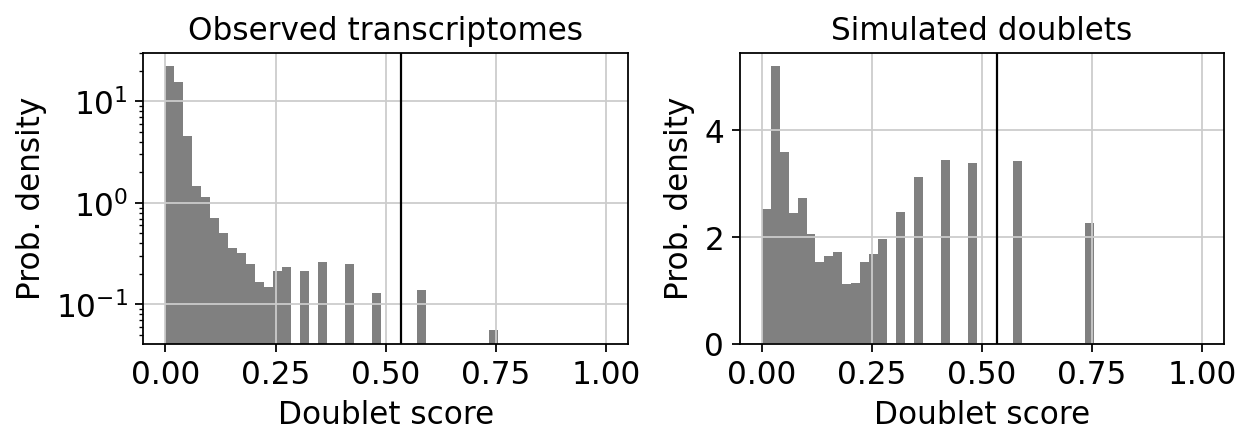

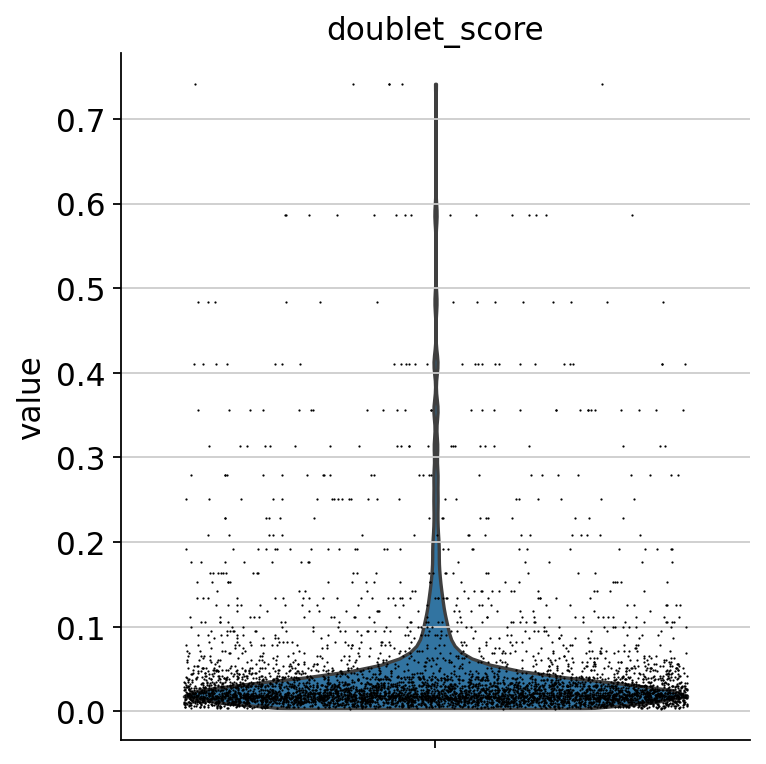

filtered out 43 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17349 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.4%
    Scrublet finished (0:00:10)


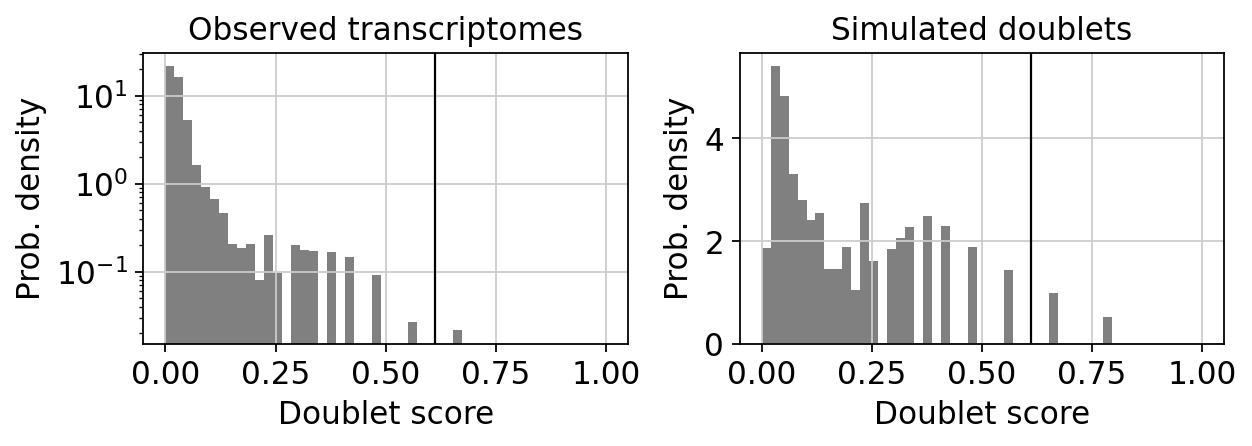

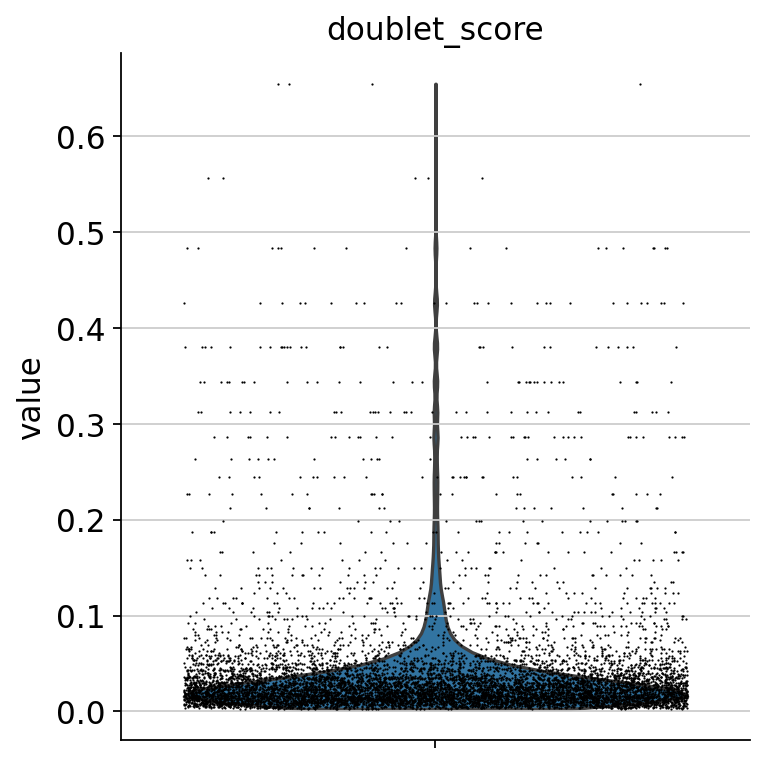

filtered out 69 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18825 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.3%
    Scrublet finished (0:00:10)


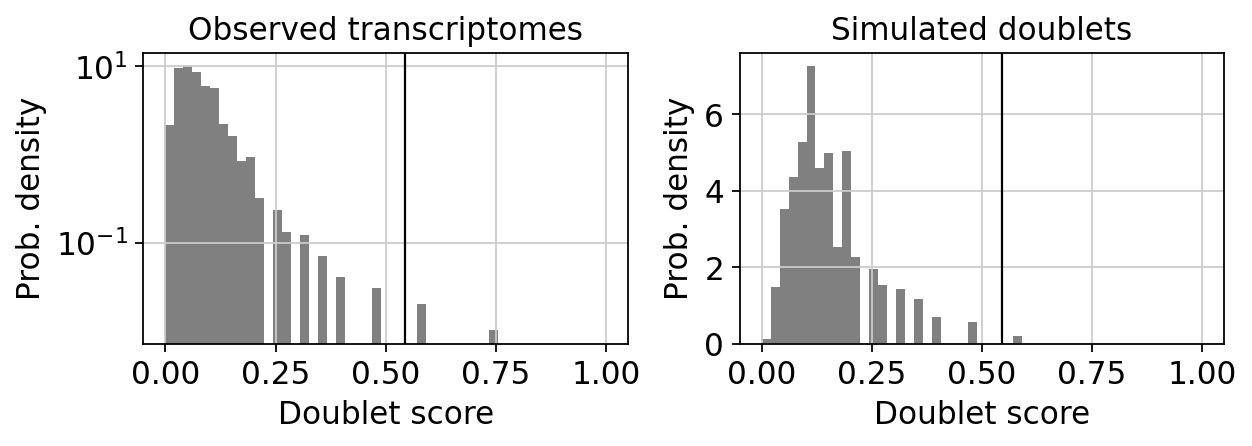

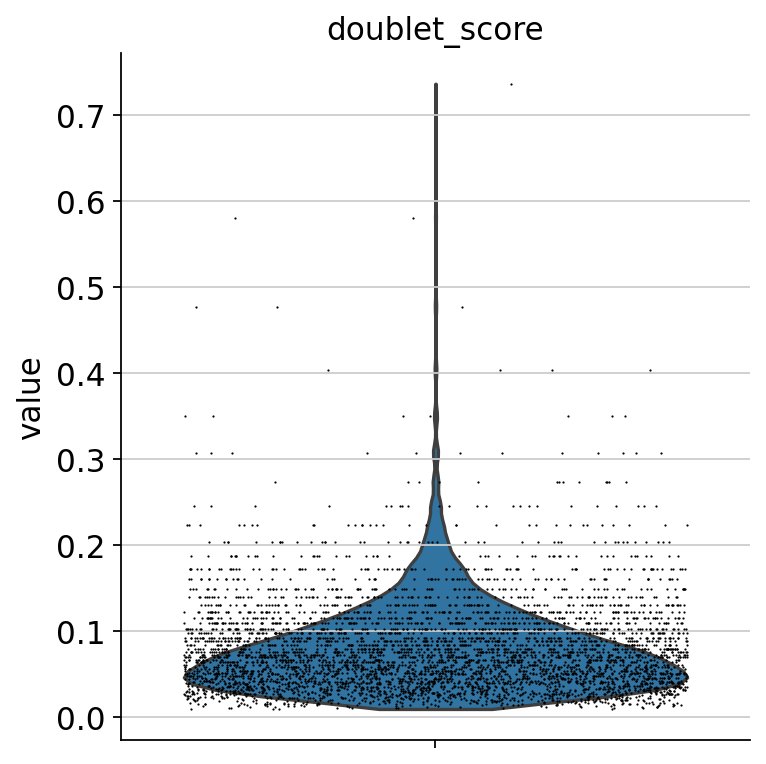

filtered out 125 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18489 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 9.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%
    Scrublet finished (0:00:06)


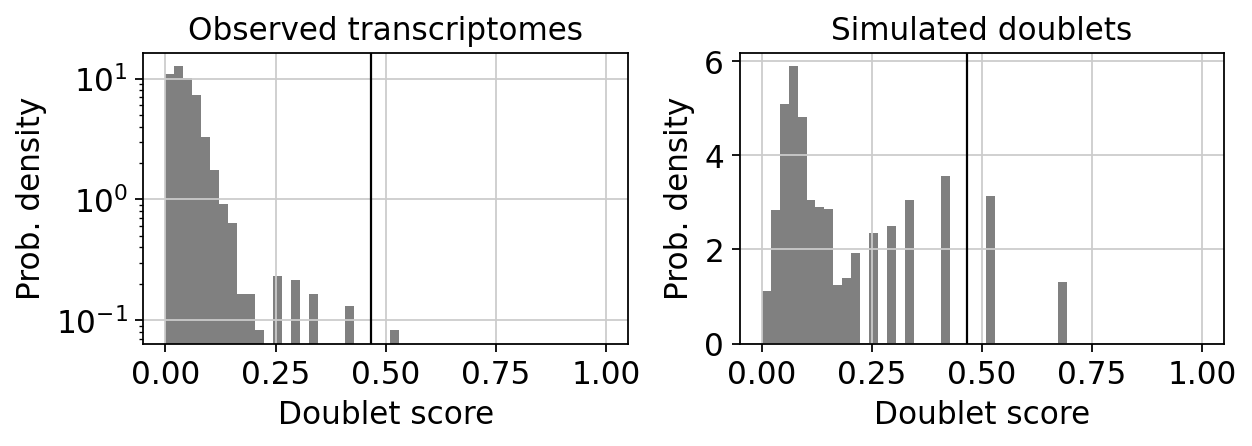

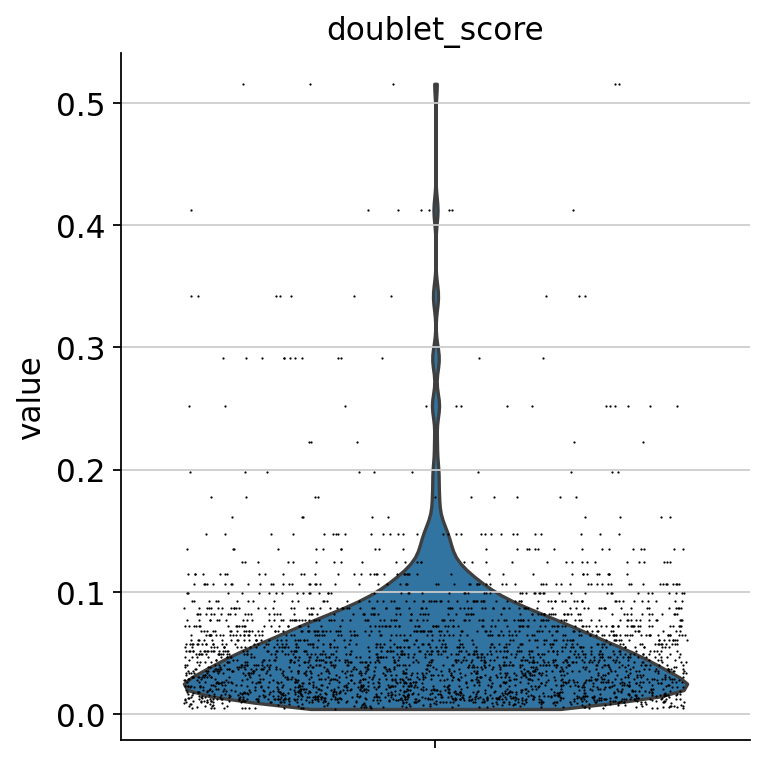

filtered out 119 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17660 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.3%
    Scrublet finished (0:00:15)


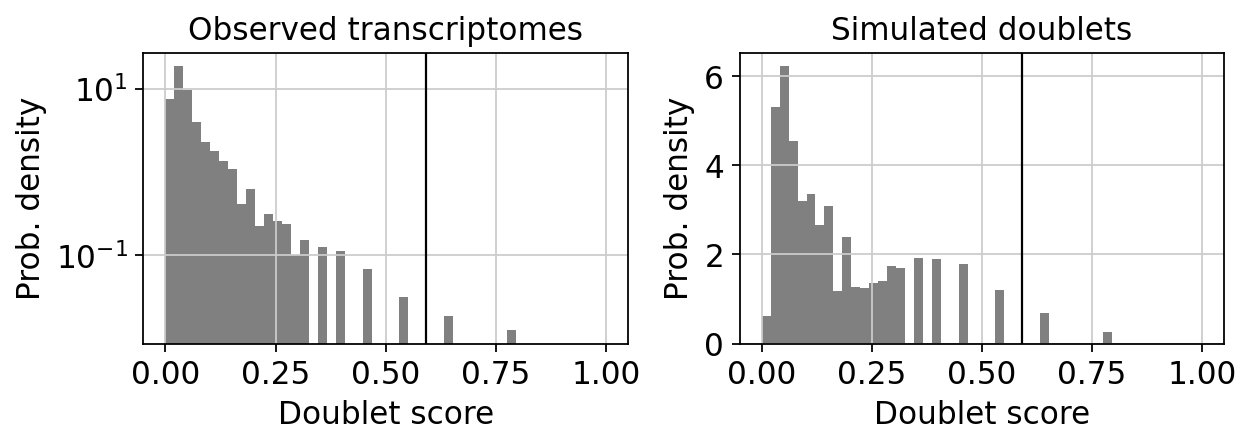

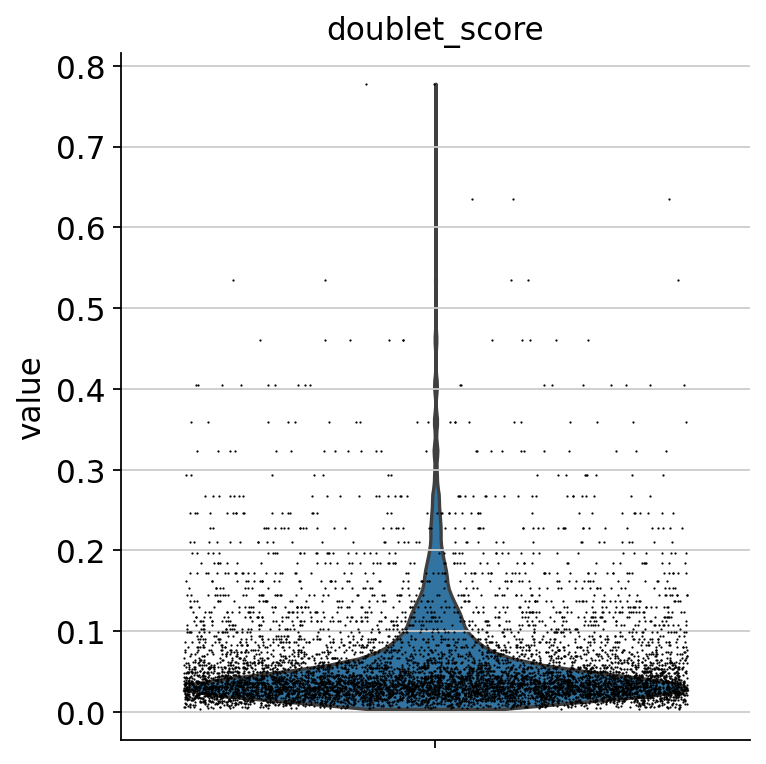

filtered out 9 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18151 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%
    Scrublet finished (0:00:07)


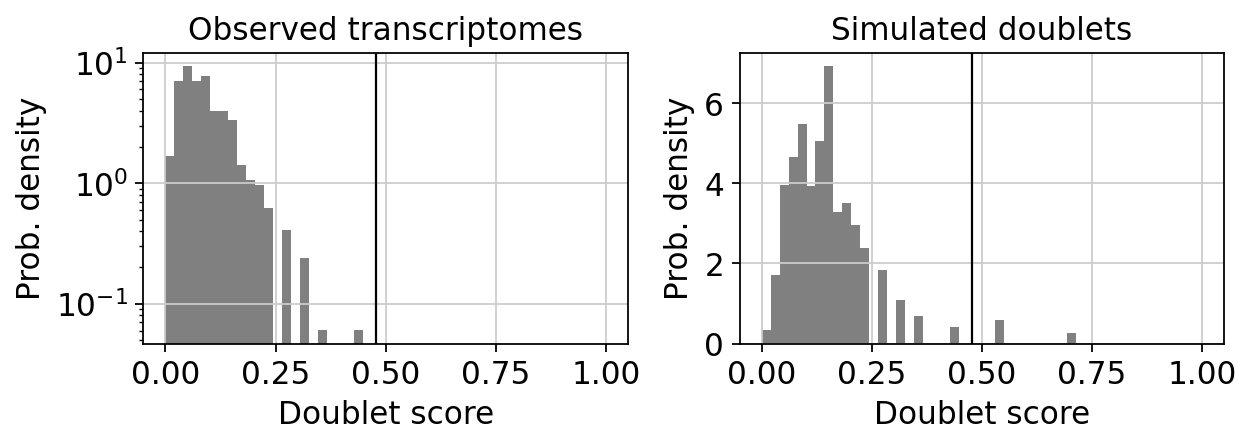

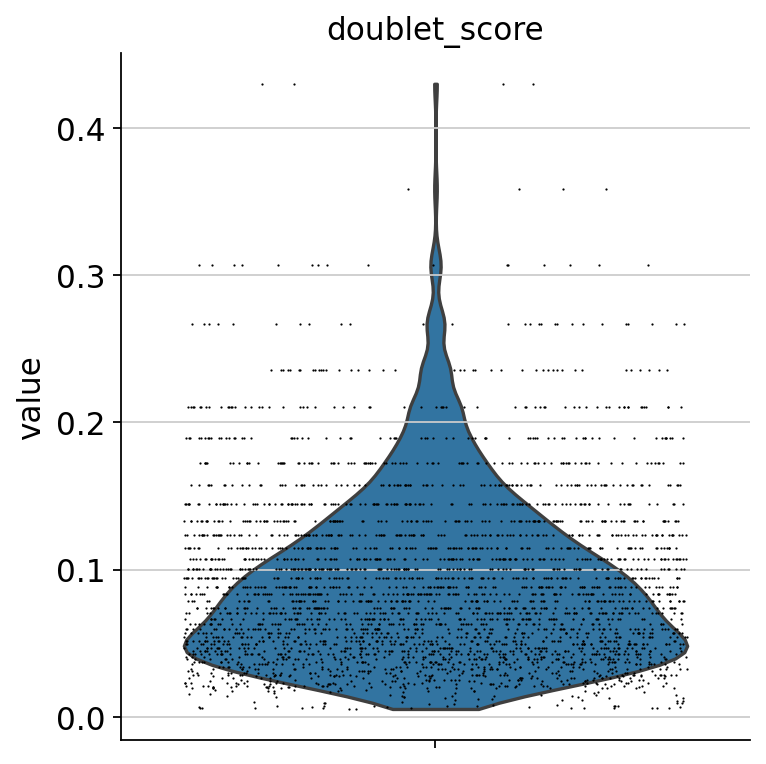

Running Scrublet
filtered out 19920 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.4%
    Scrublet finished (0:00:05)


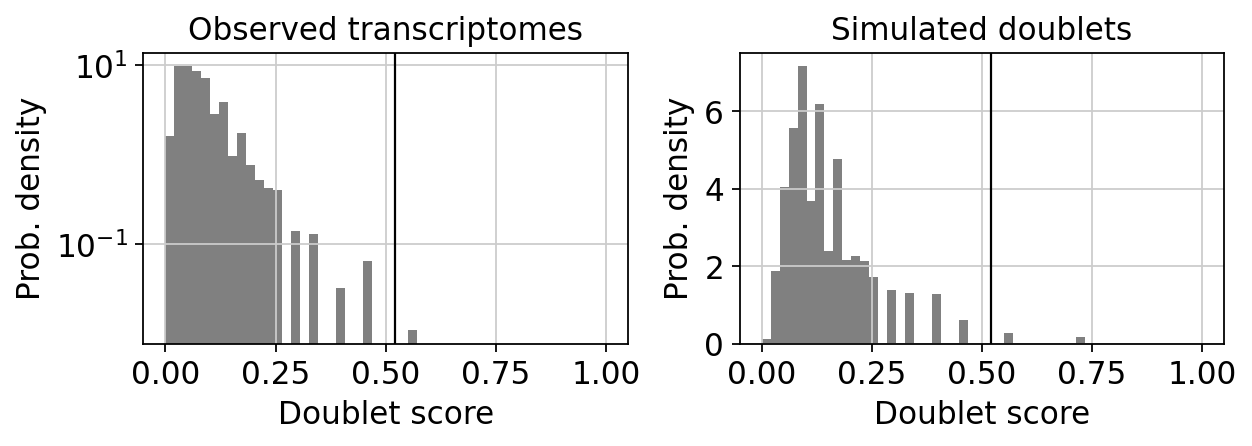

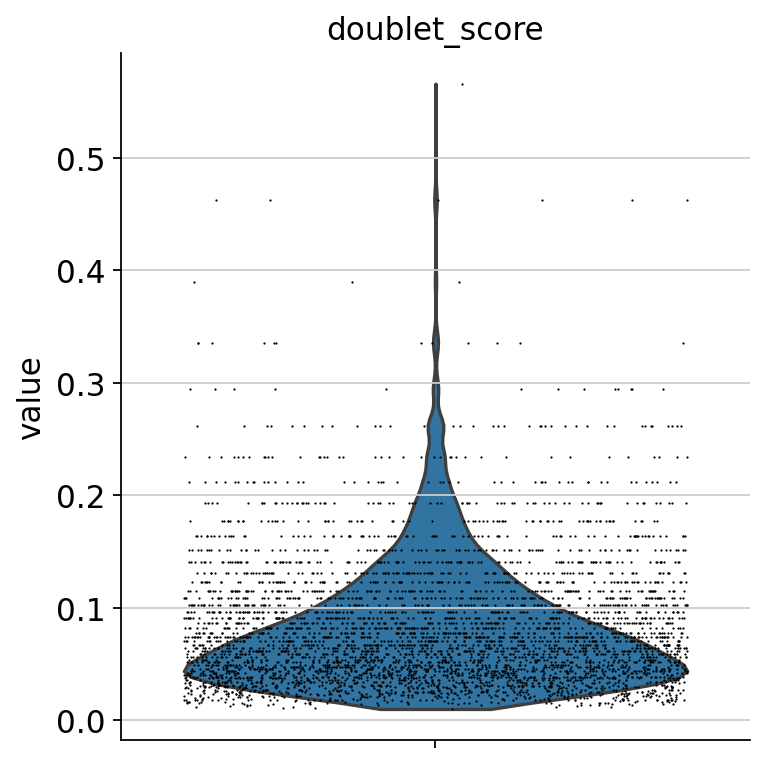

filtered out 68 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17854 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.4%
    Scrublet finished (0:00:10)


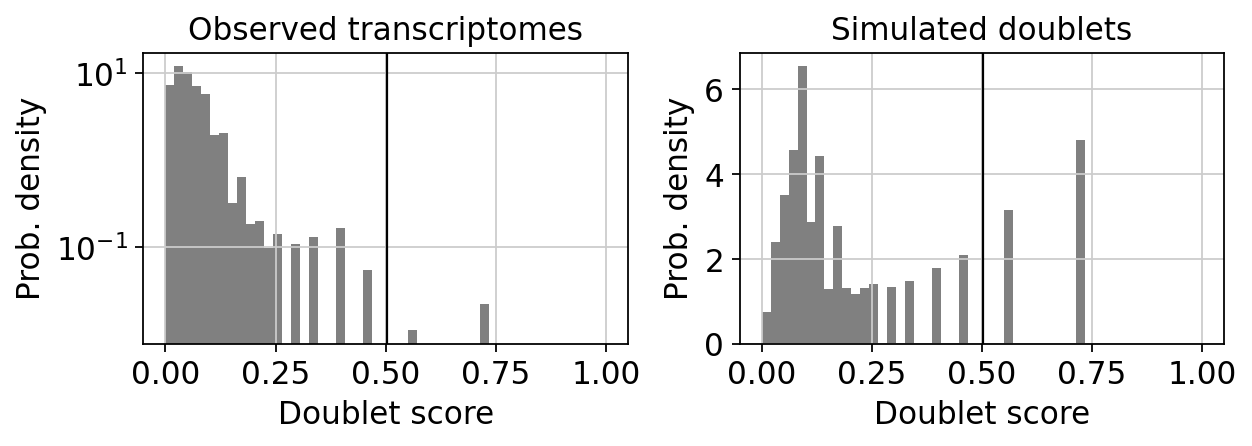

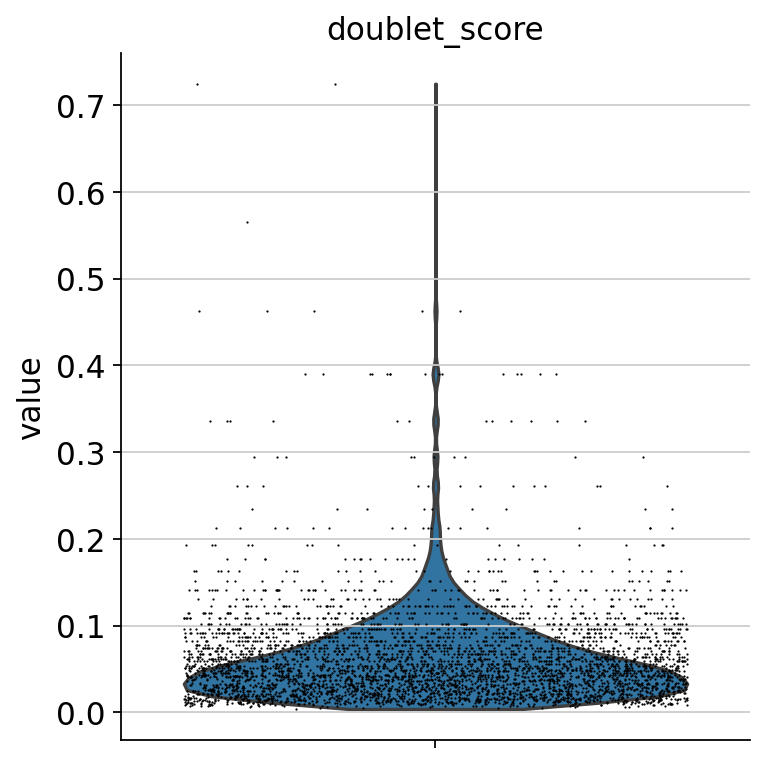

filtered out 249 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18262 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.1%
    Scrublet finished (0:00:11)


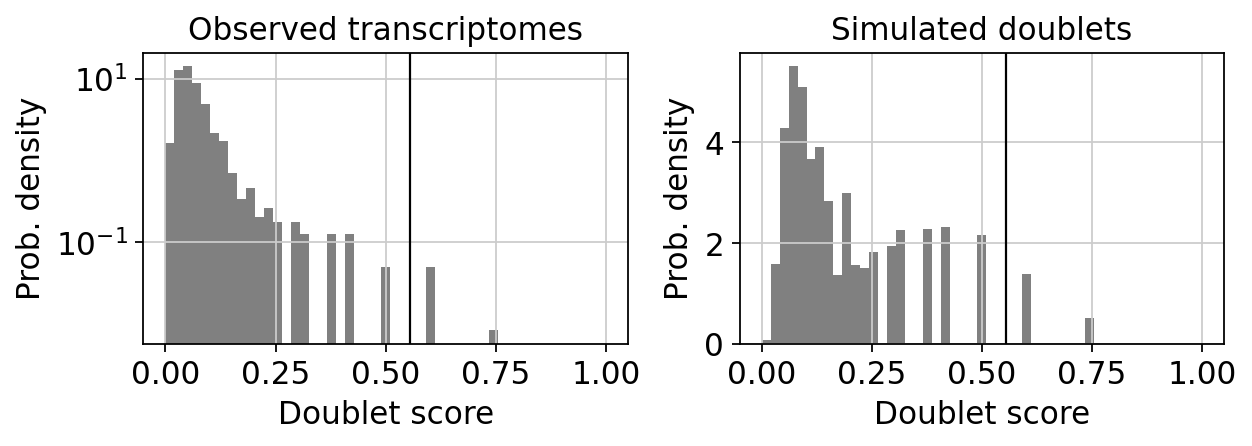

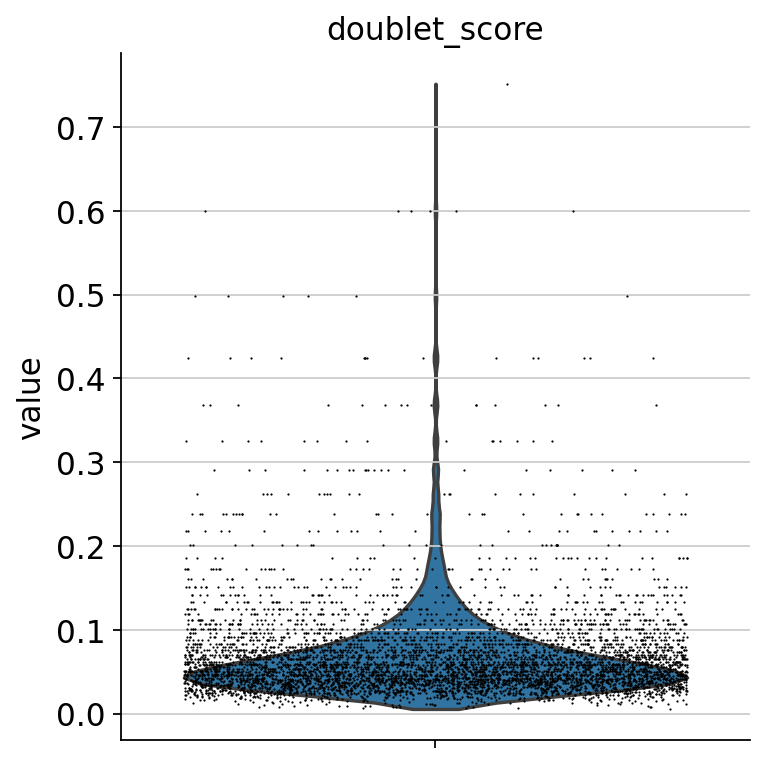

filtered out 39 cells that have less than 200 genes expressed
Running Scrublet
filtered out 20007 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.8%
    Scrublet finished (0:00:05)


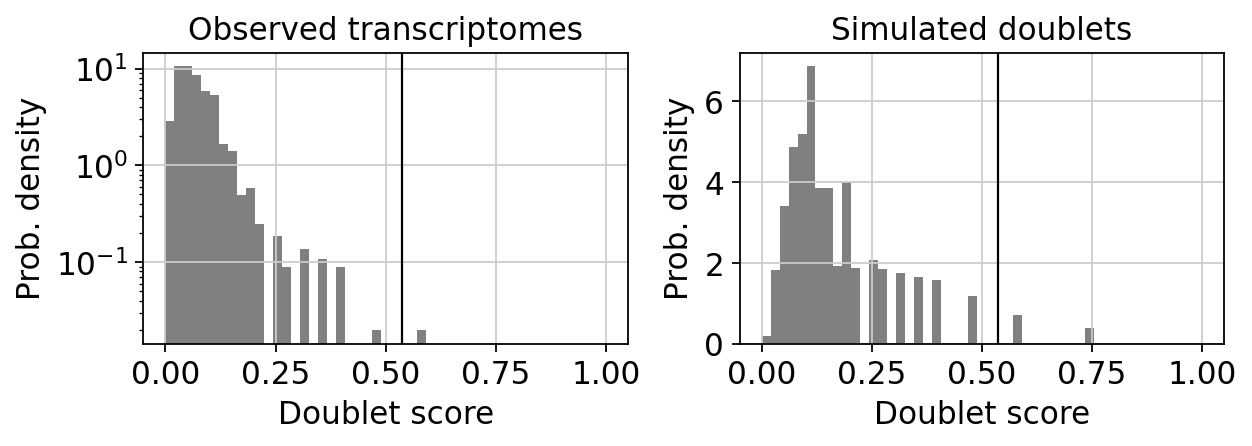

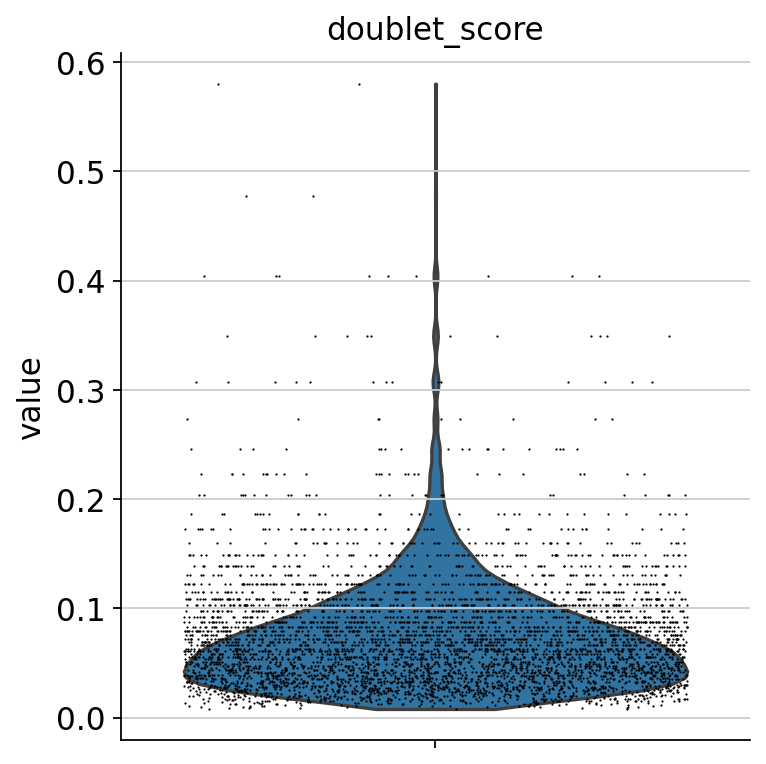

filtered out 35 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18759 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.50
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.2%
    Scrublet finished (0:00:07)


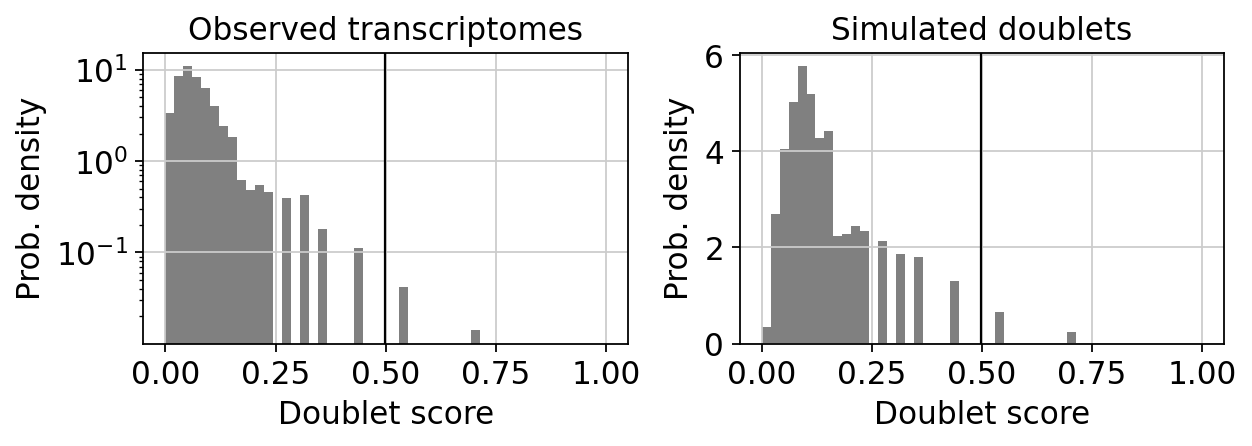

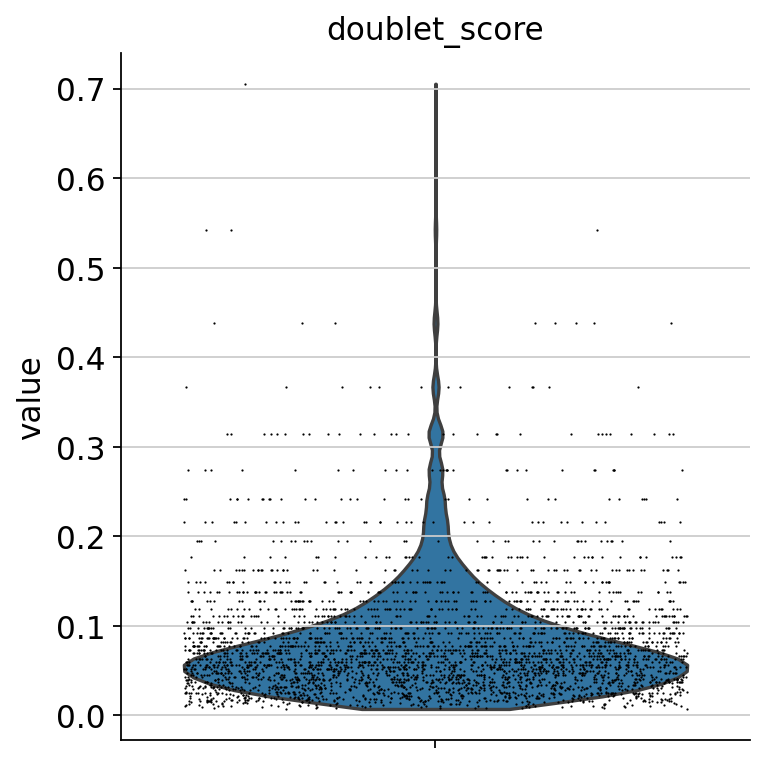

Running Scrublet
filtered out 18890 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.0%
    Scrublet finished (0:00:06)


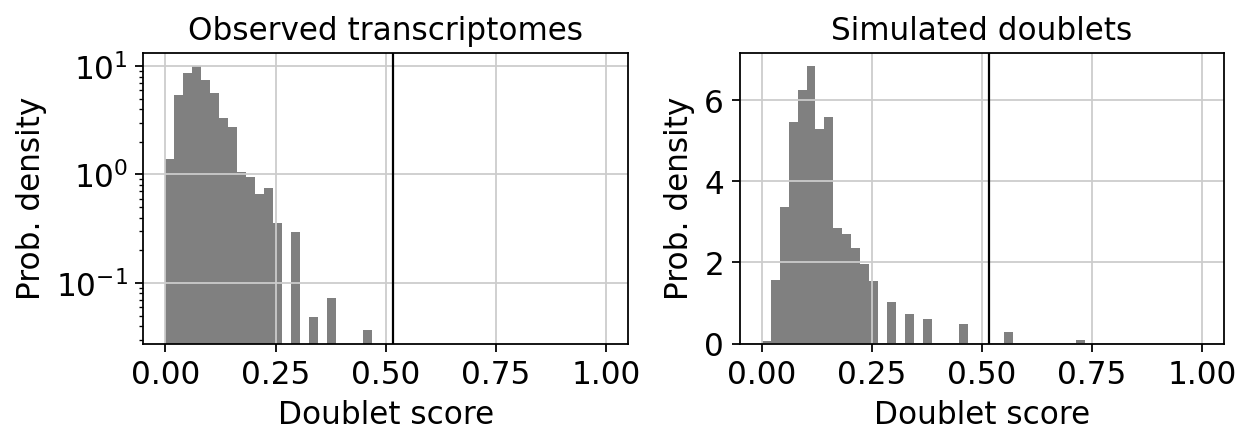

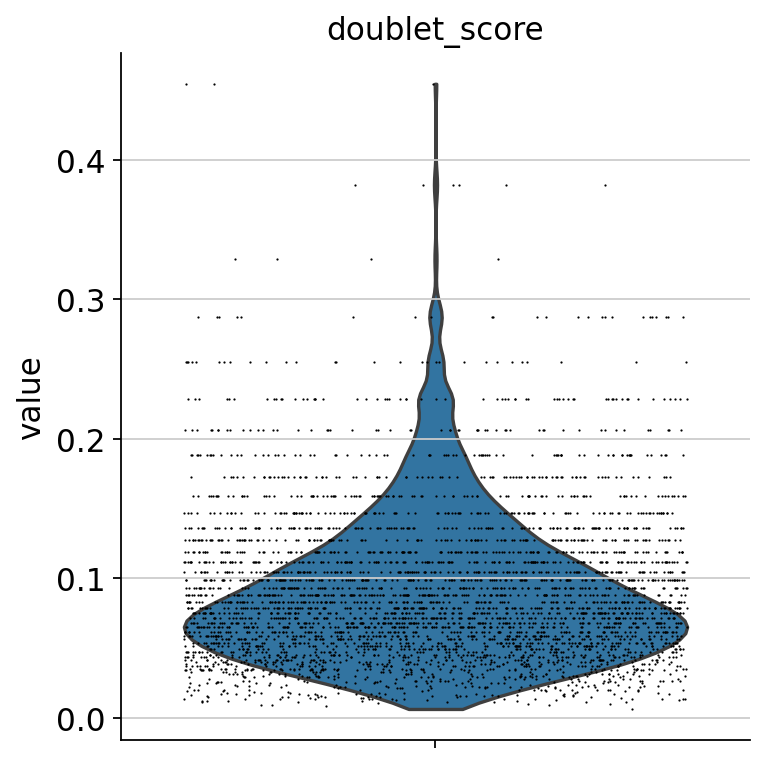

filtered out 16 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18731 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 3.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.4%
    Scrublet finished (0:00:09)


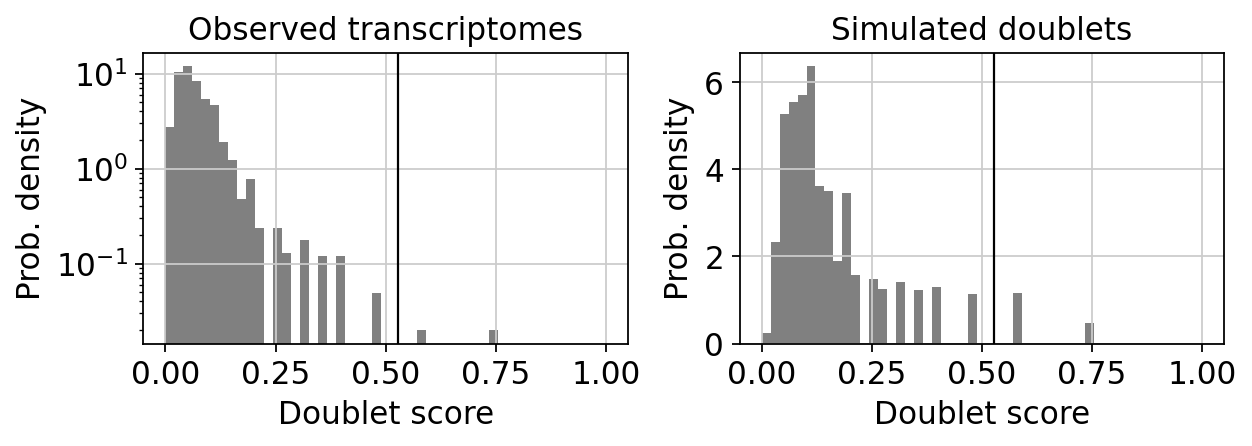

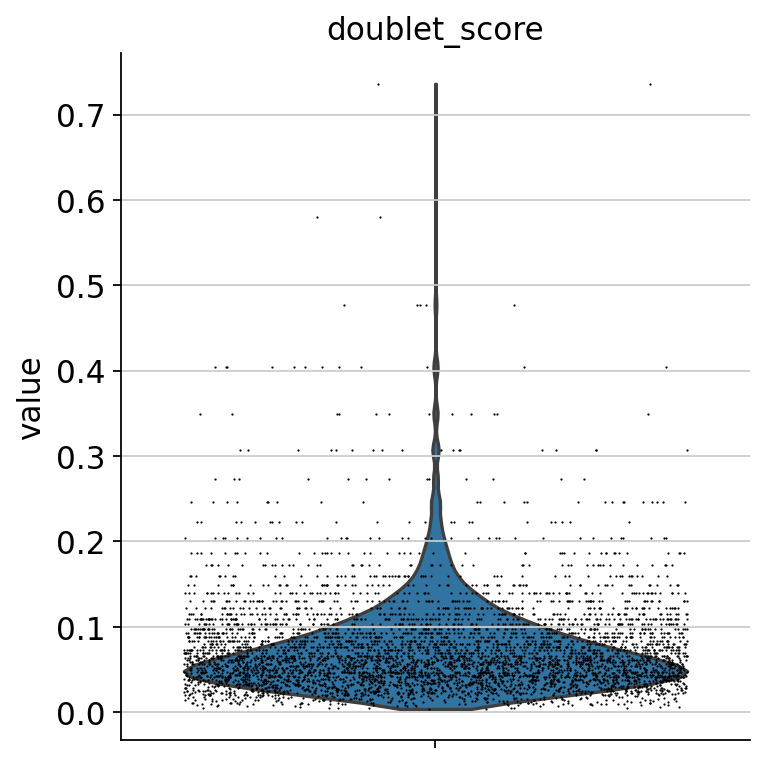

filtered out 3 cells that have less than 200 genes expressed
Running Scrublet
filtered out 22007 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid th

Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 6.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.8%
    Scrublet finished (0:00:02)


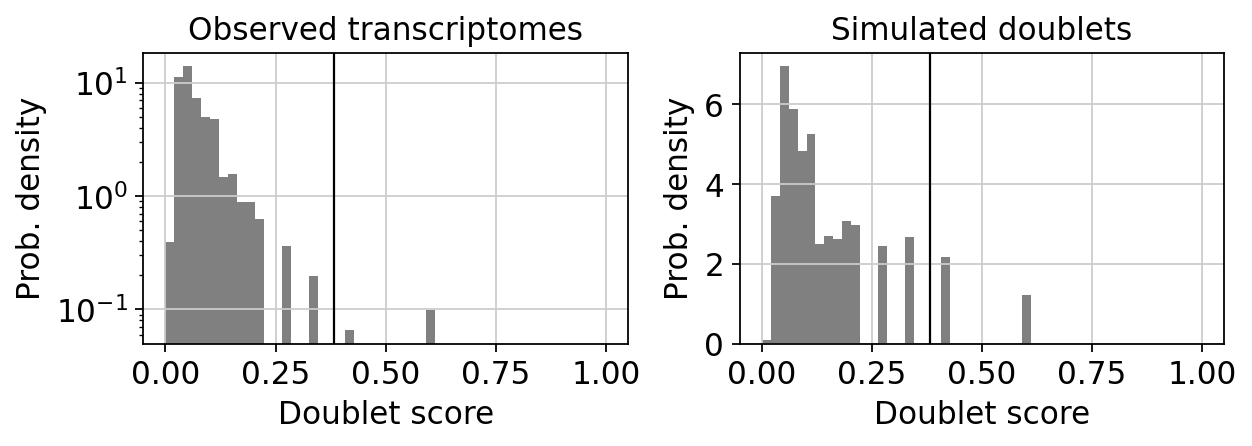

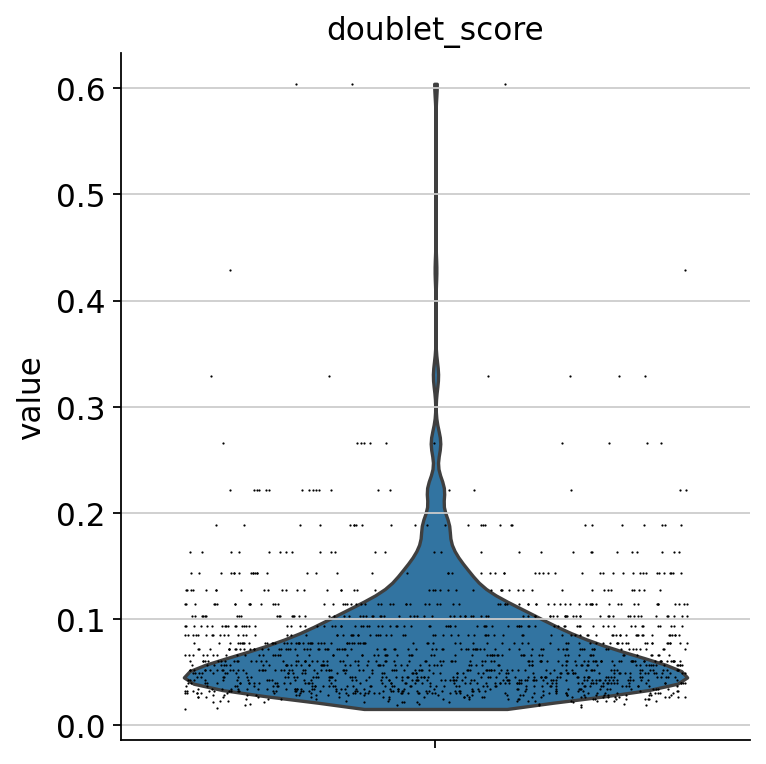

filtered out 109 cells that have less than 200 genes expressed
Running Scrublet
filtered out 15743 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 8.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.6%
    Scrublet finished (0:00:14)


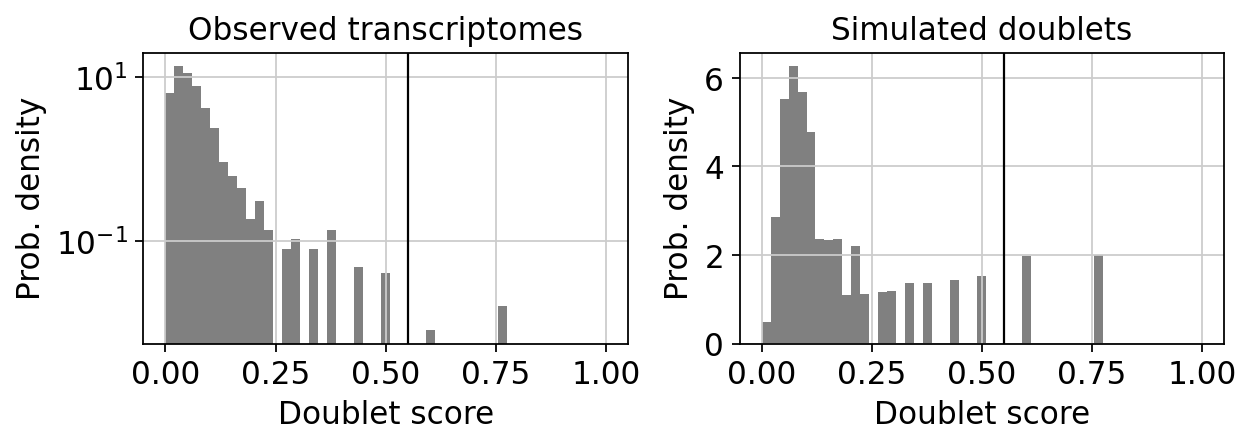

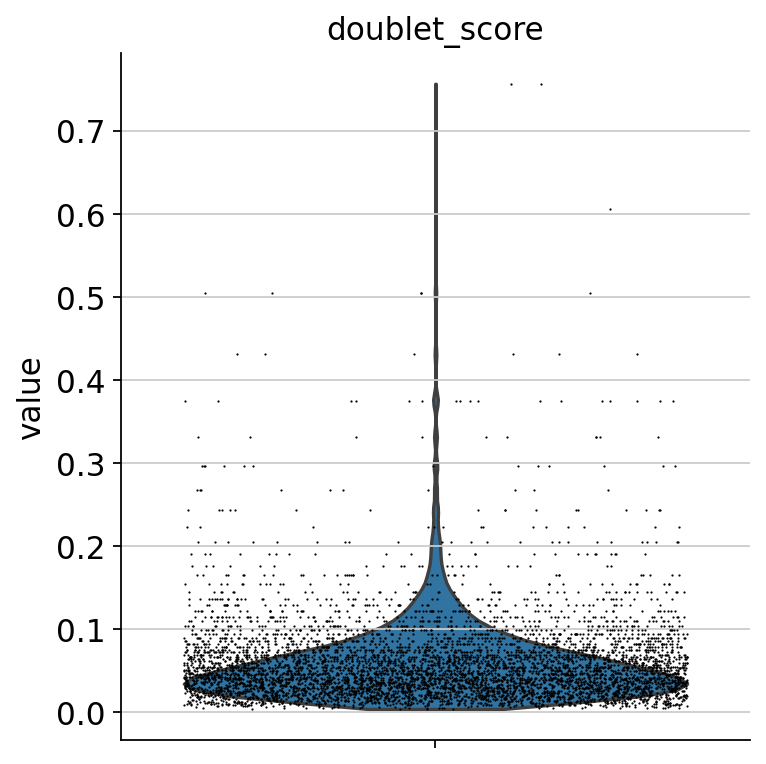

filtered out 27 cells that have less than 200 genes expressed
Running Scrublet
filtered out 24188 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid th

Automatically set threshold at doublet score = 0.22
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 24.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.0%
    Scrublet finished (0:00:00)


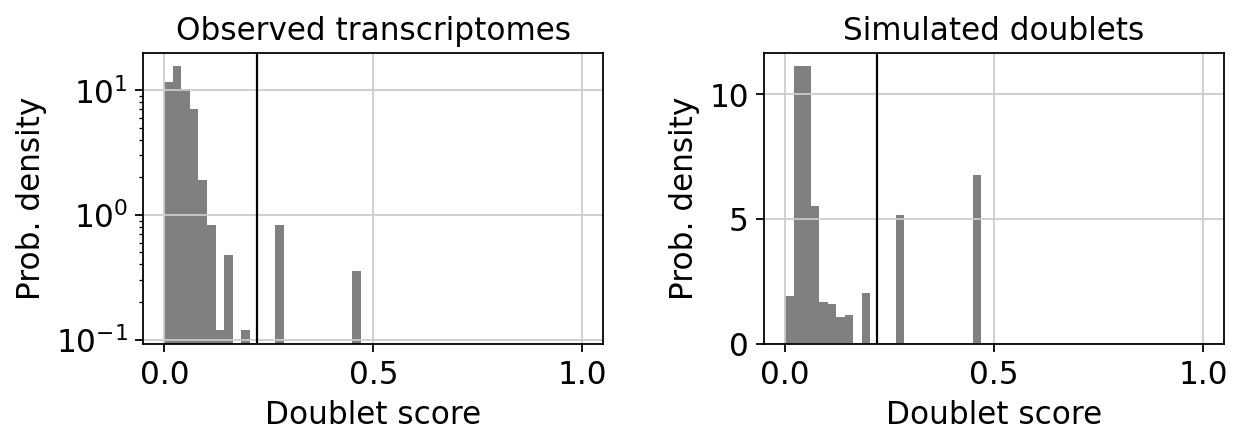

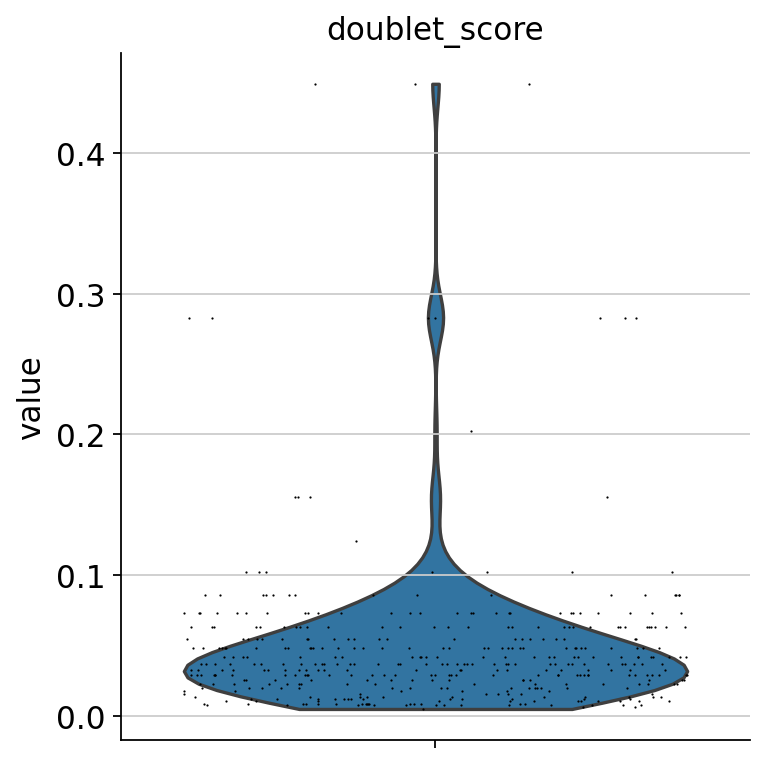

filtered out 48 cells that have less than 200 genes expressed
Running Scrublet
filtered out 19768 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid th

Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 23.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%
    Scrublet finished (0:00:03)


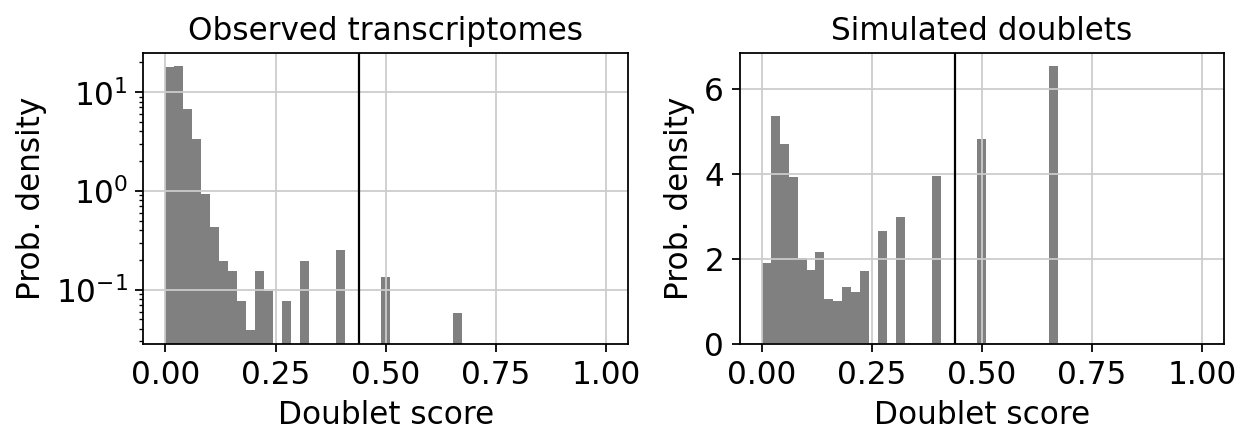

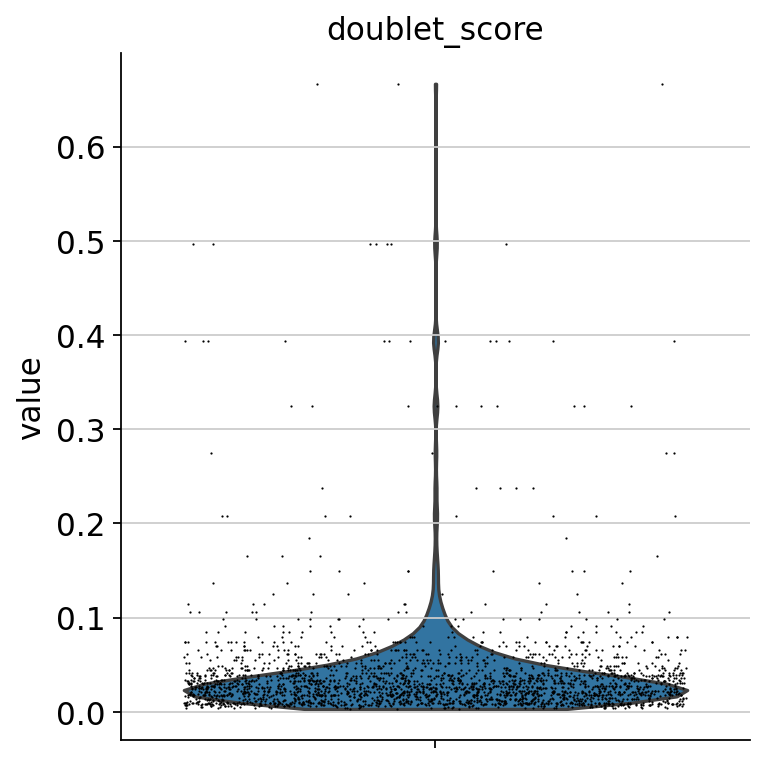

filtered out 45 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17080 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 3.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.5%
    Scrublet finished (0:00:08)


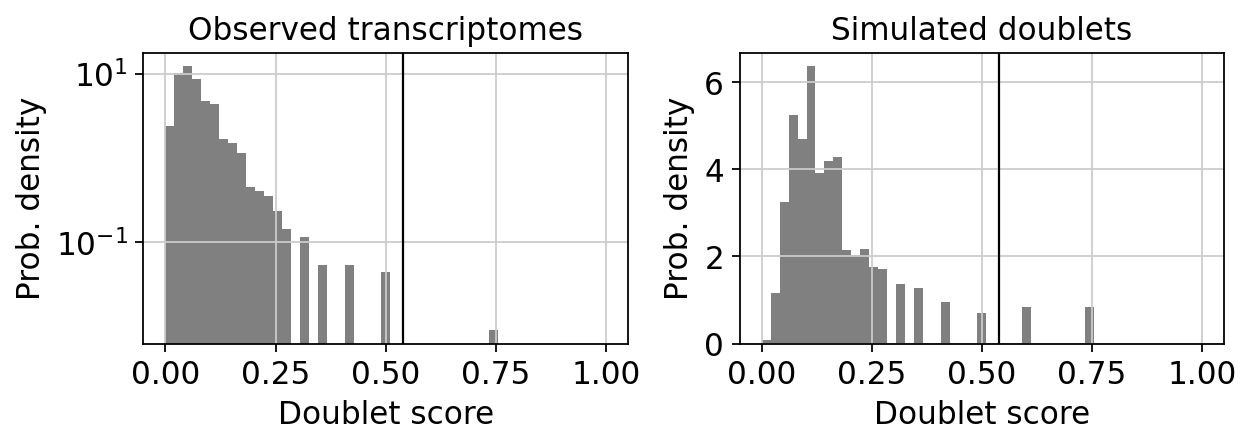

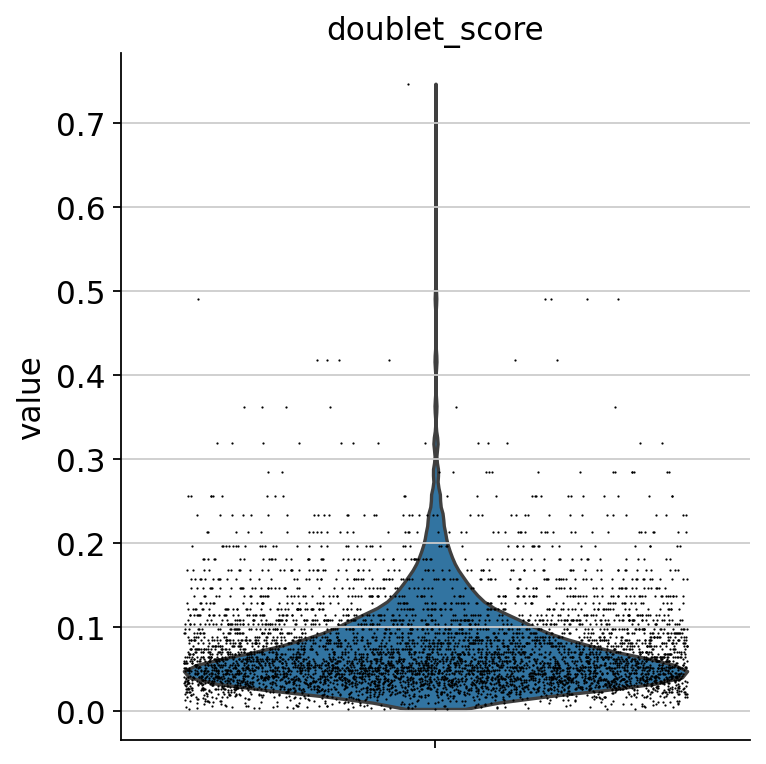

filtered out 50 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17696 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%
    Scrublet finished (0:00:10)


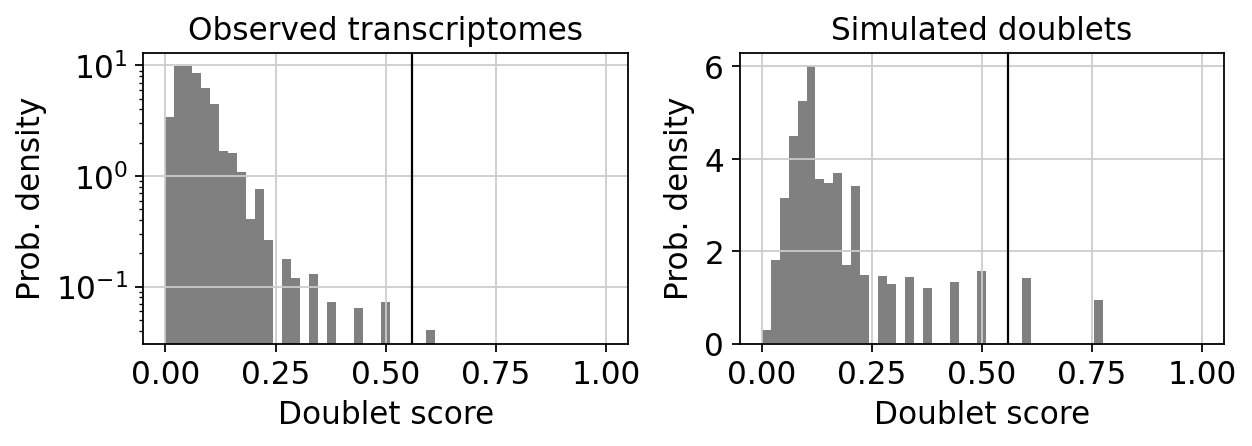

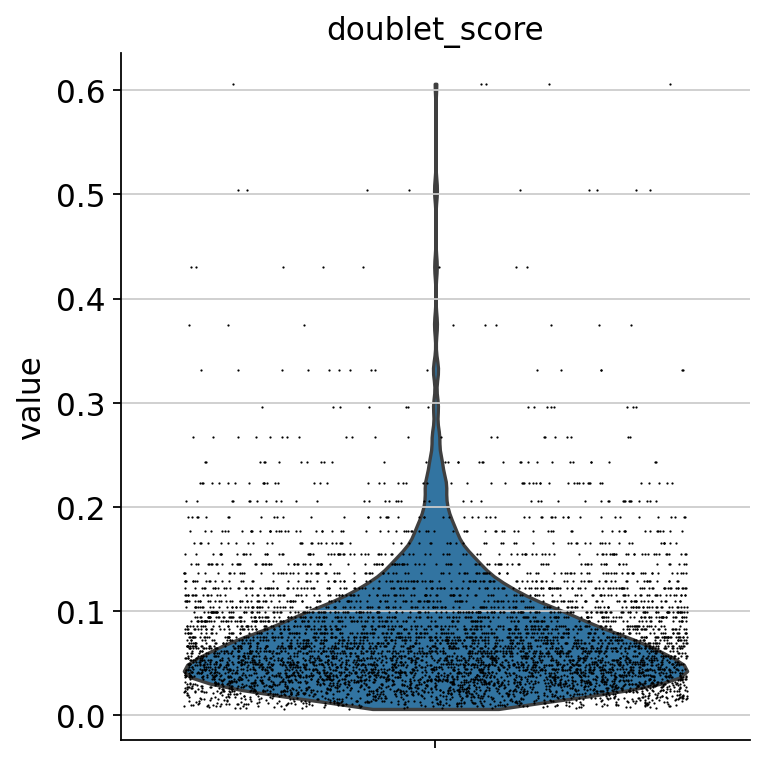

filtered out 83 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17667 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%
    Scrublet finished (0:00:08)


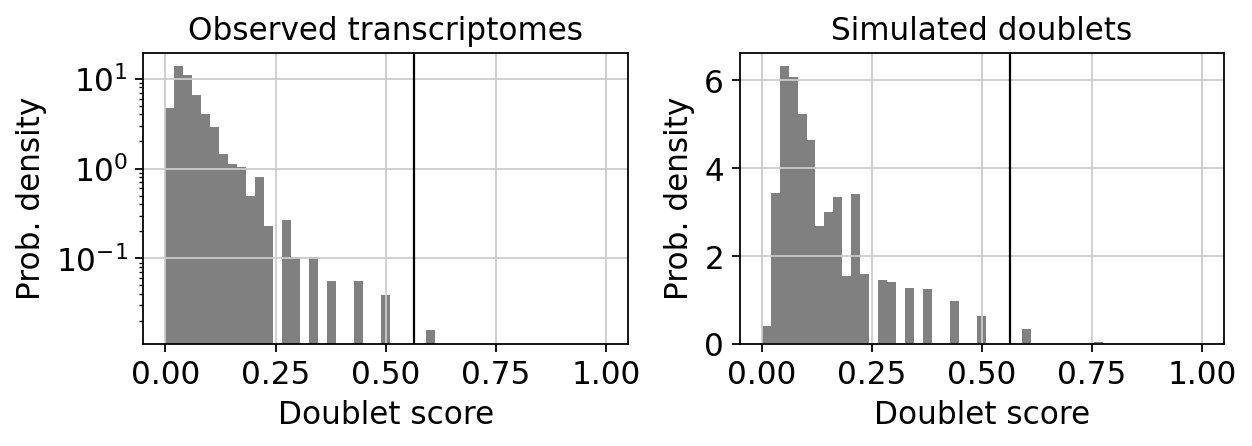

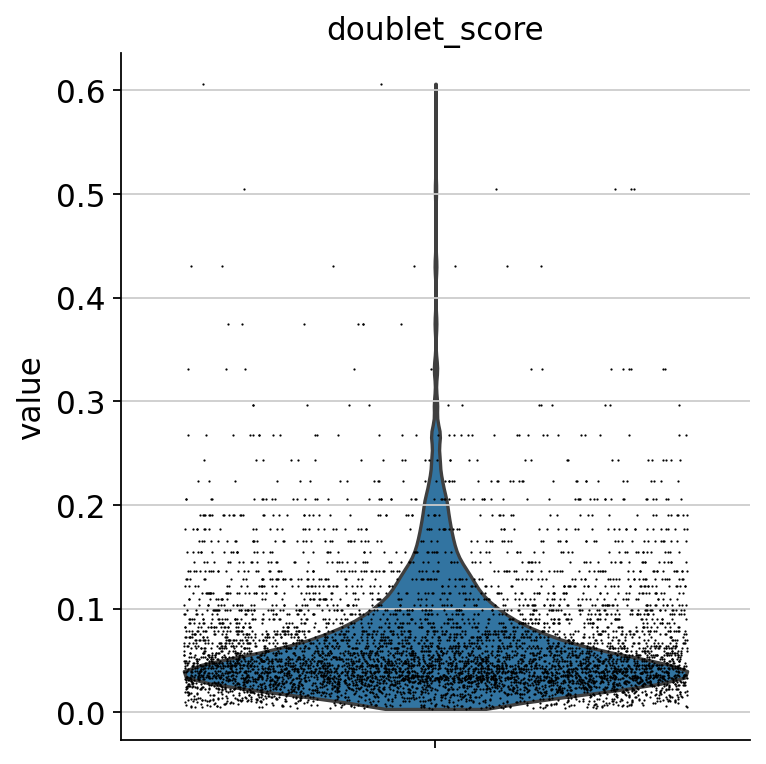

filtered out 67 cells that have less than 200 genes expressed
Running Scrublet
filtered out 18132 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 39.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.5%
    Scrublet finished (0:00:05)


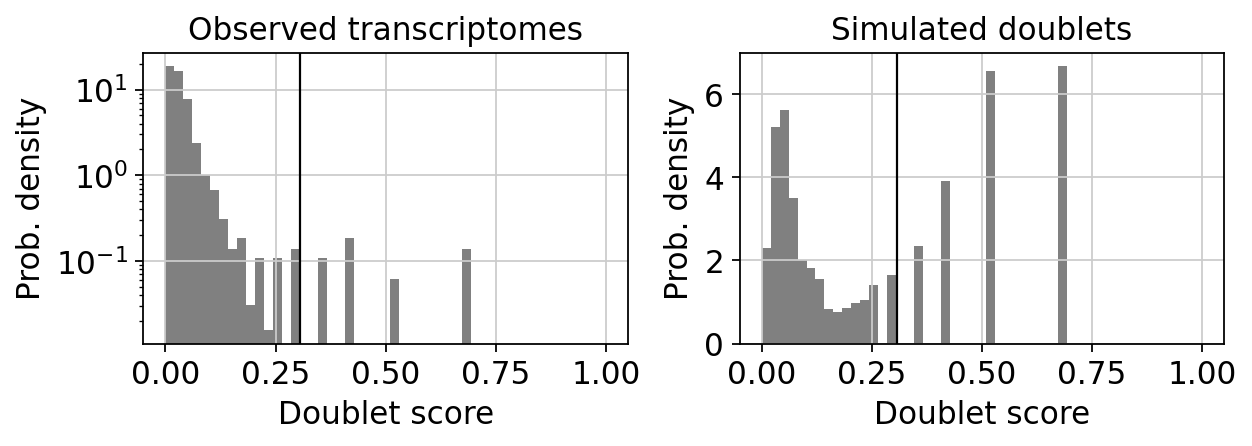

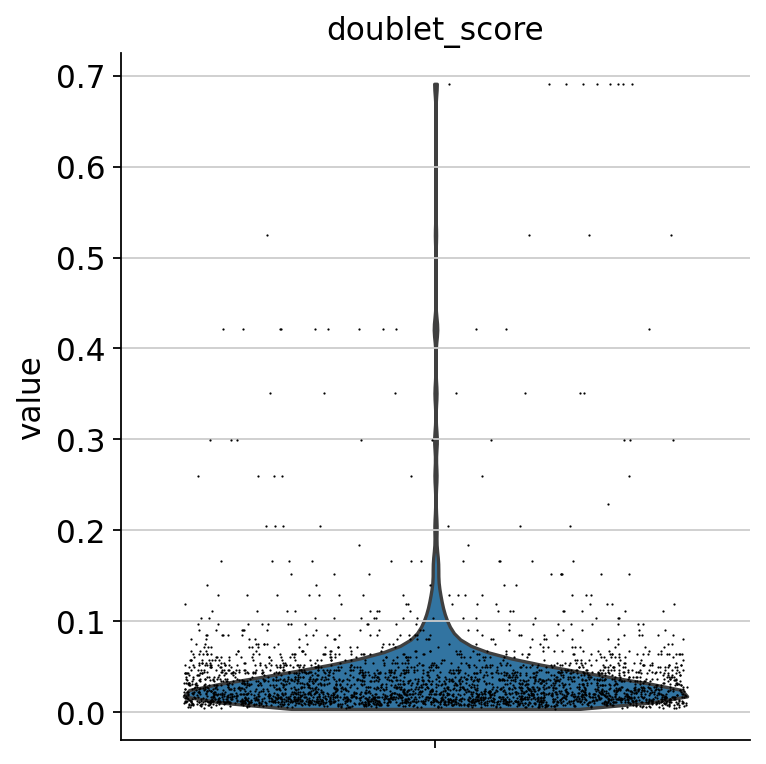

filtered out 53 cells that have less than 200 genes expressed
Running Scrublet
filtered out 19302 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.49
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 20.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.4%
    Scrublet finished (0:00:06)


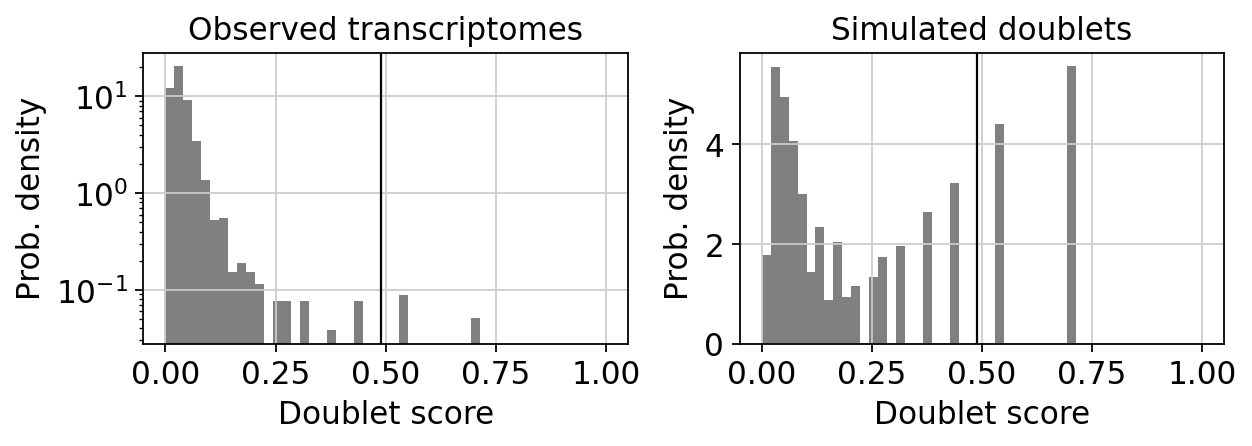

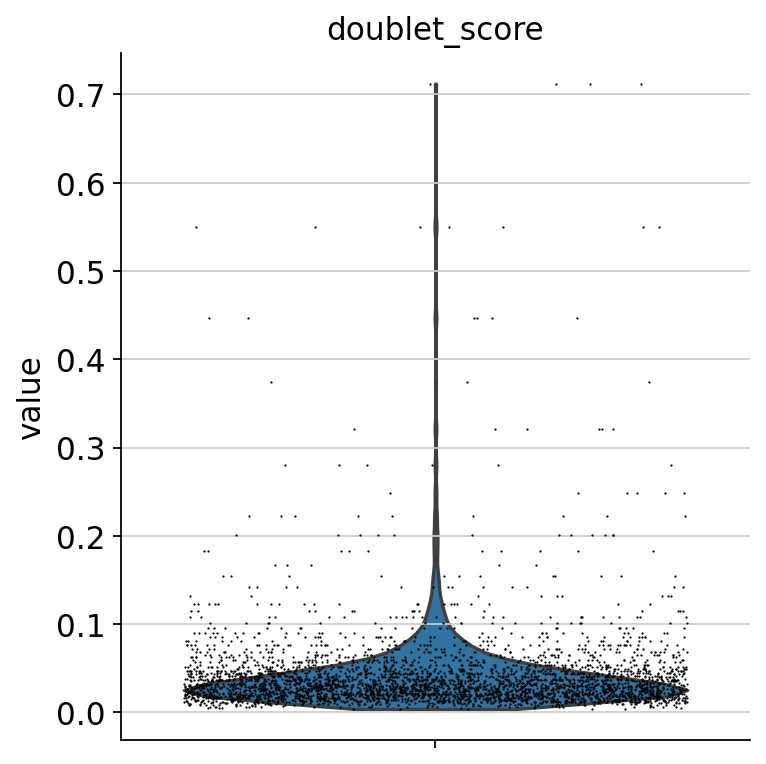

filtered out 26 cells that have less than 200 genes expressed
Running Scrublet
filtered out 20143 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.4%
    Scrublet finished (0:00:05)


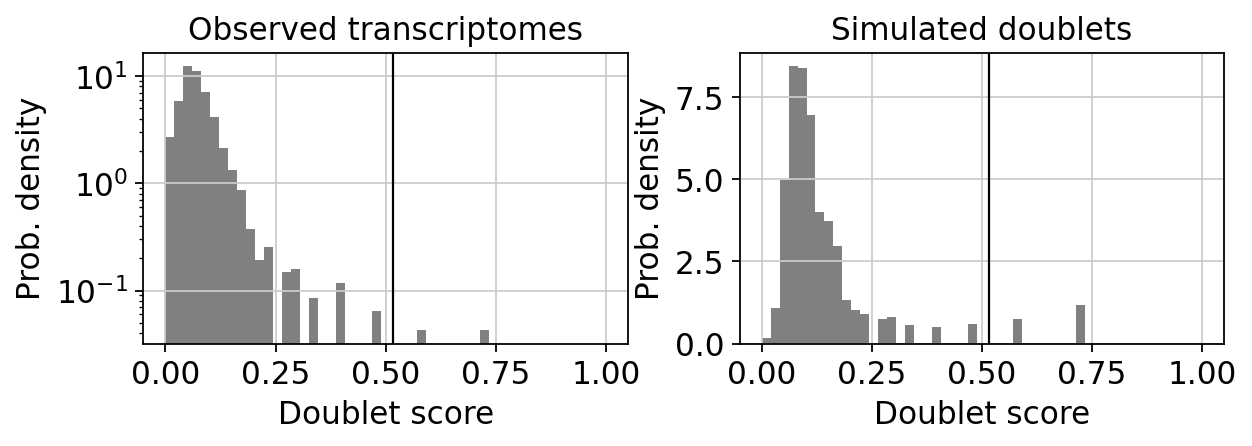

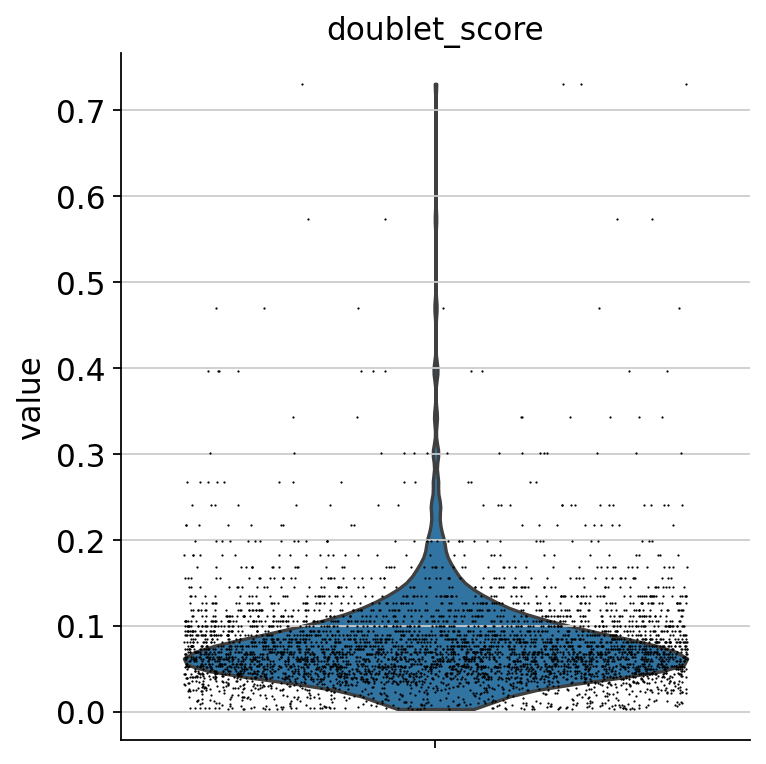

filtered out 34 cells that have less than 200 genes expressed
Running Scrublet
filtered out 19264 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.1%
    Scrublet finished (0:00:08)


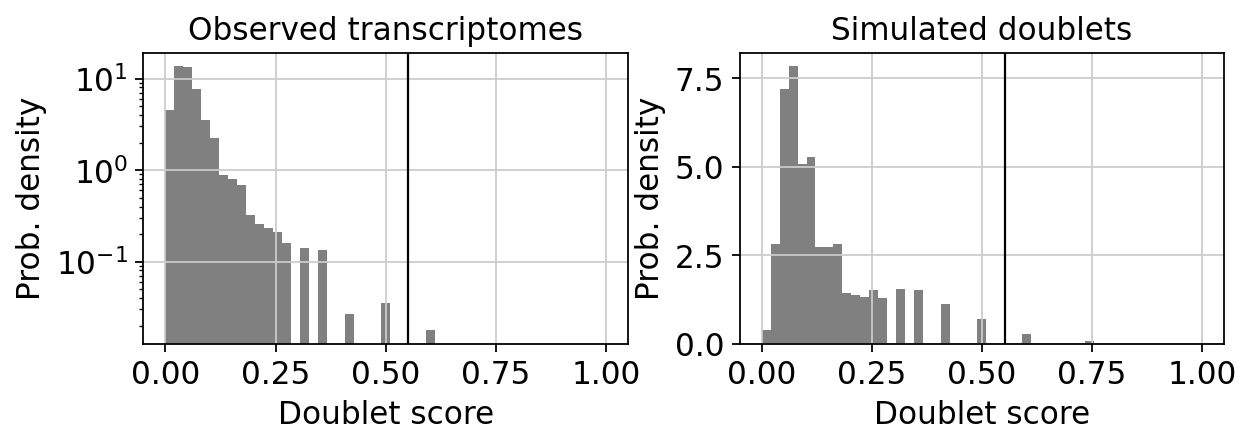

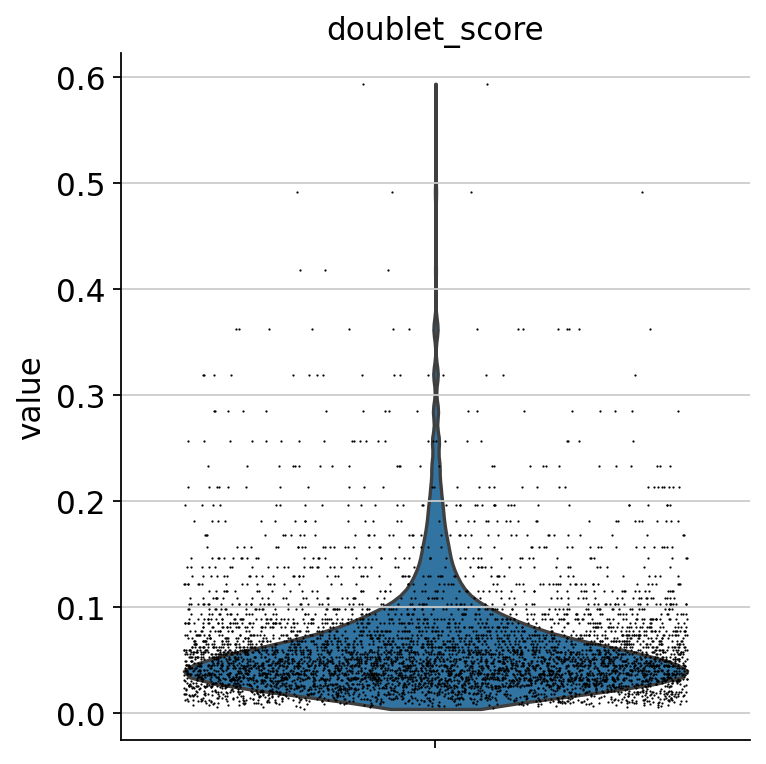

filtered out 25 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17088 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 57.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.1%
    Scrublet finished (0:00:09)


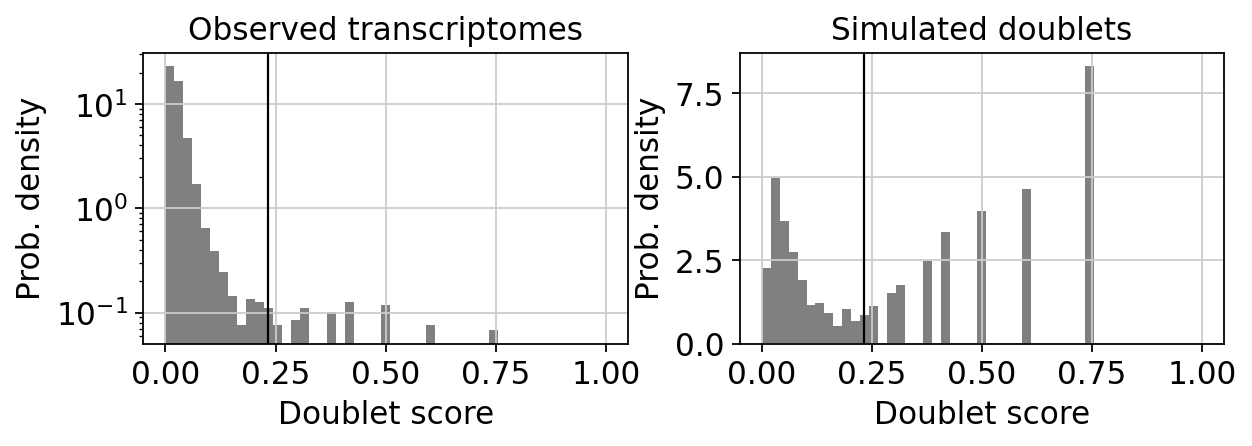

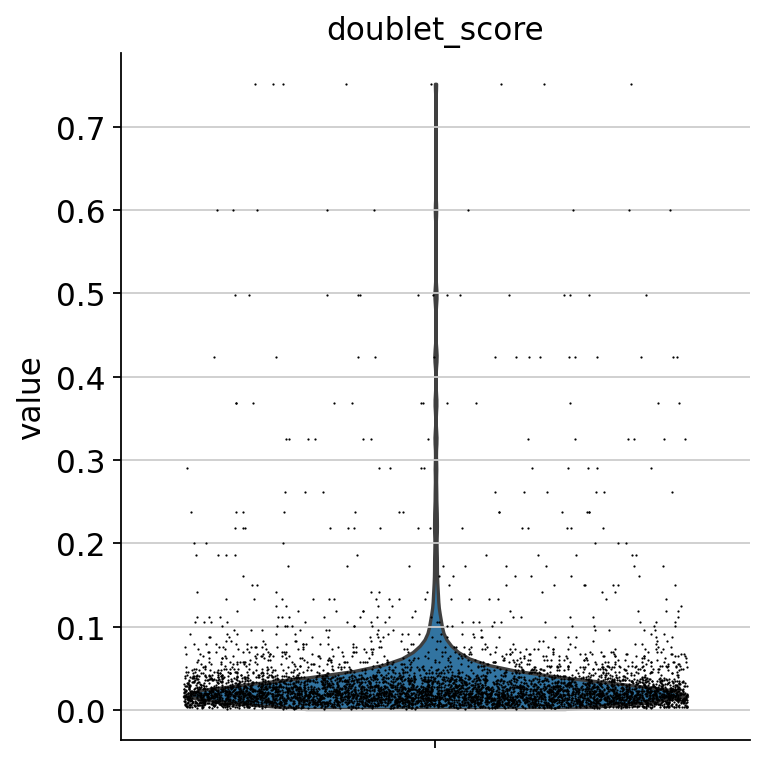

filtered out 19 cells that have less than 200 genes expressed
Running Scrublet
filtered out 16724 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 4.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.8%
    Scrublet finished (0:00:18)


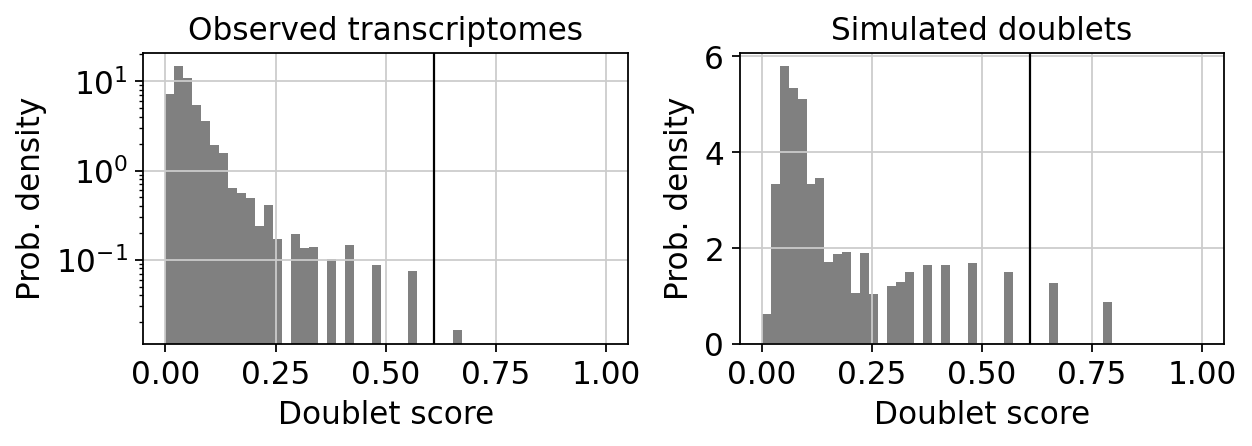

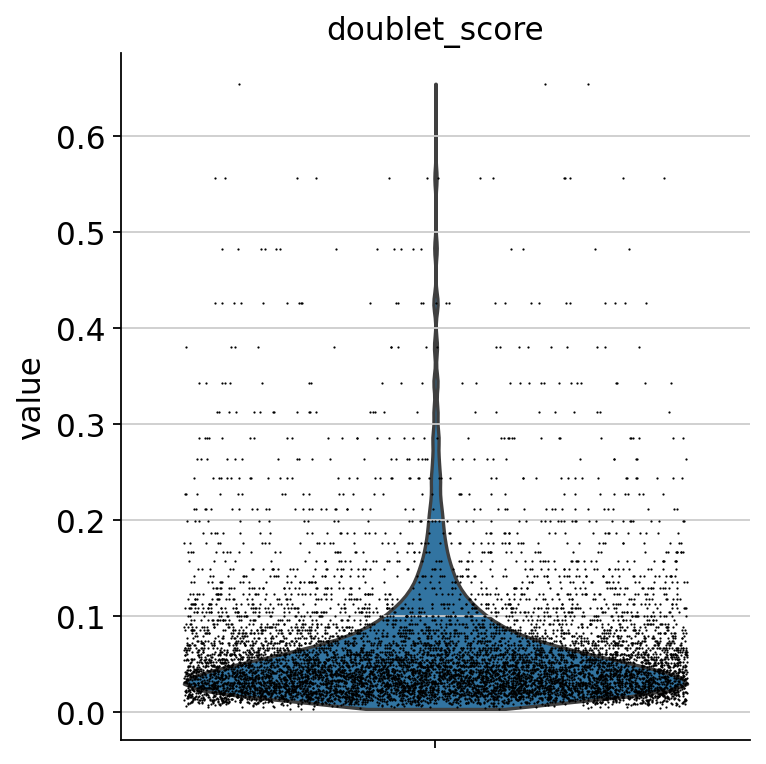

filtered out 106 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17121 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 6.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.7%
    Scrublet finished (0:00:09)


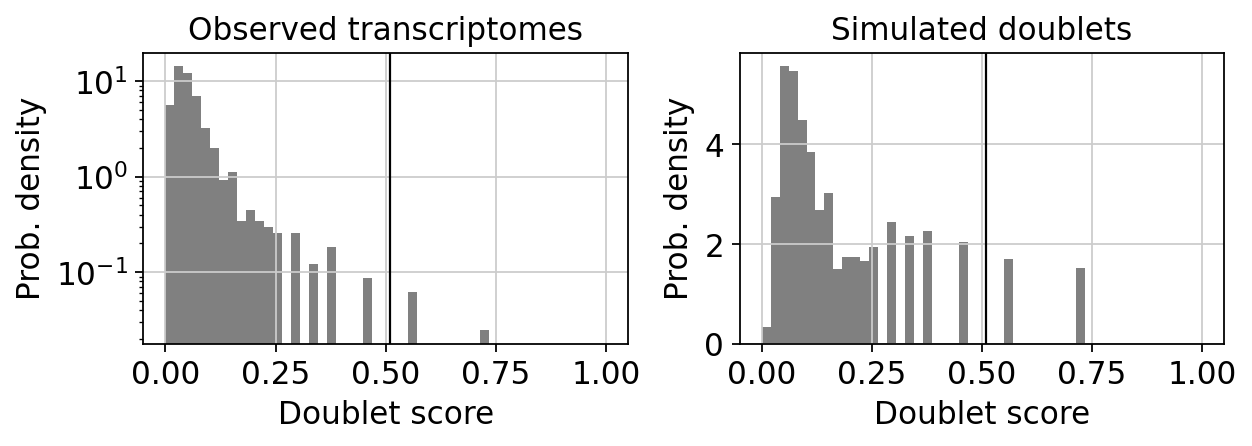

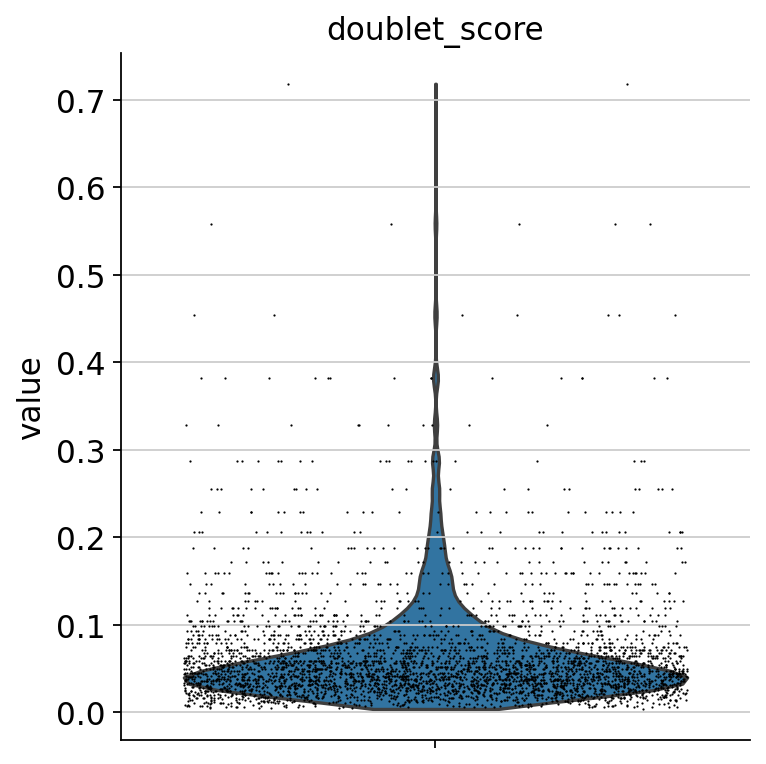

filtered out 72 cells that have less than 200 genes expressed
Running Scrublet
filtered out 15860 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.59
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 10.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.4%
    Scrublet finished (0:00:16)


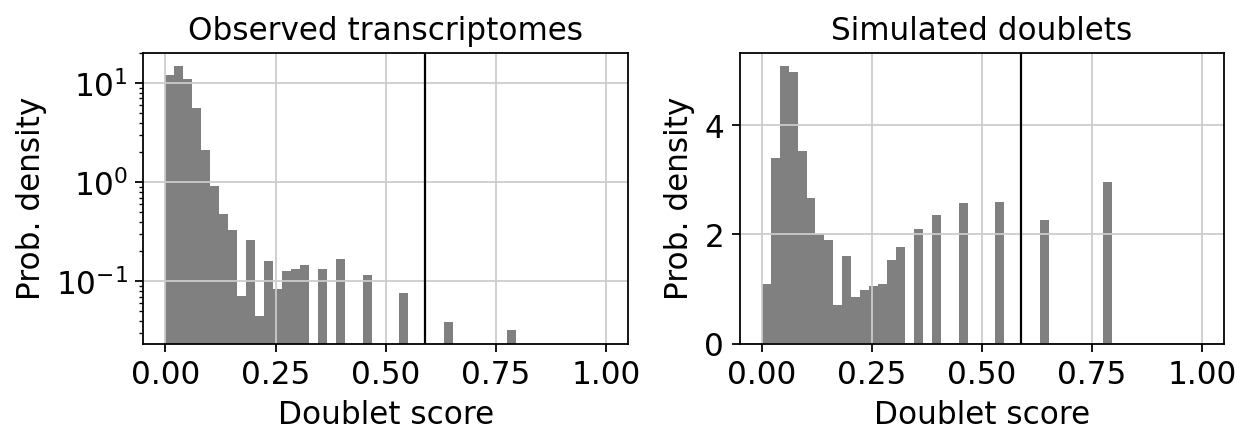

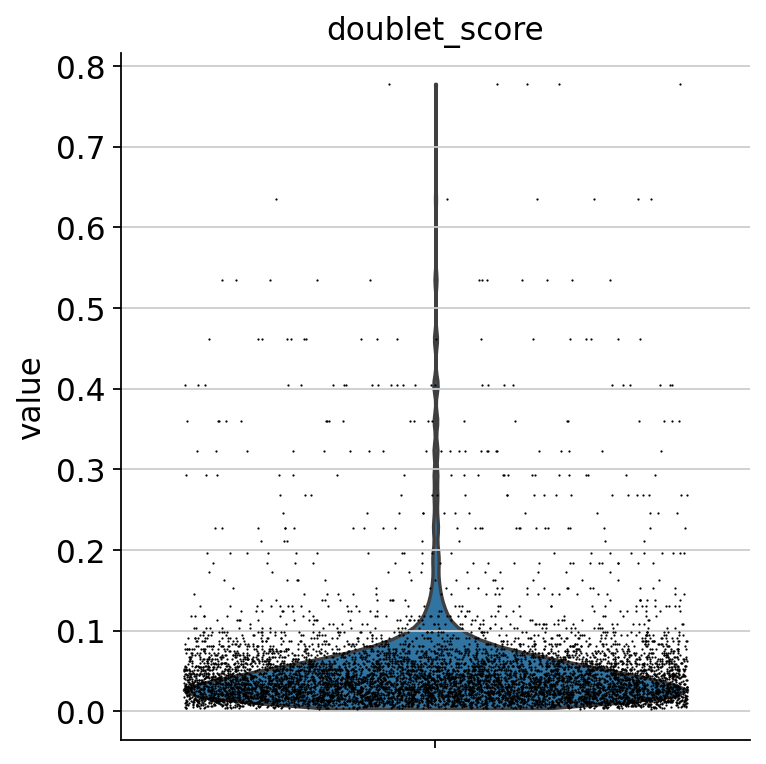

filtered out 3 cells that have less than 200 genes expressed
Running Scrublet
filtered out 19843 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.4%
    Scrublet finished (0:00:05)


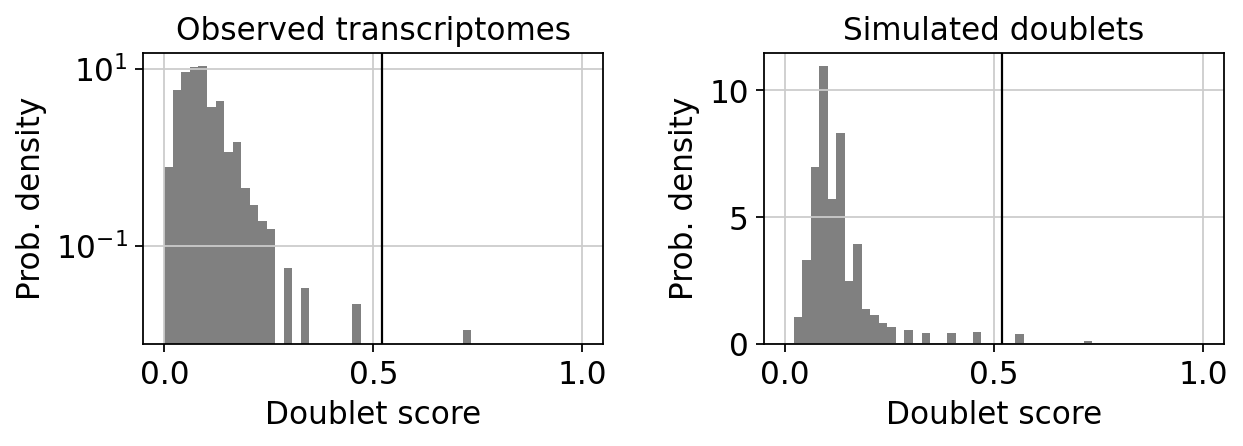

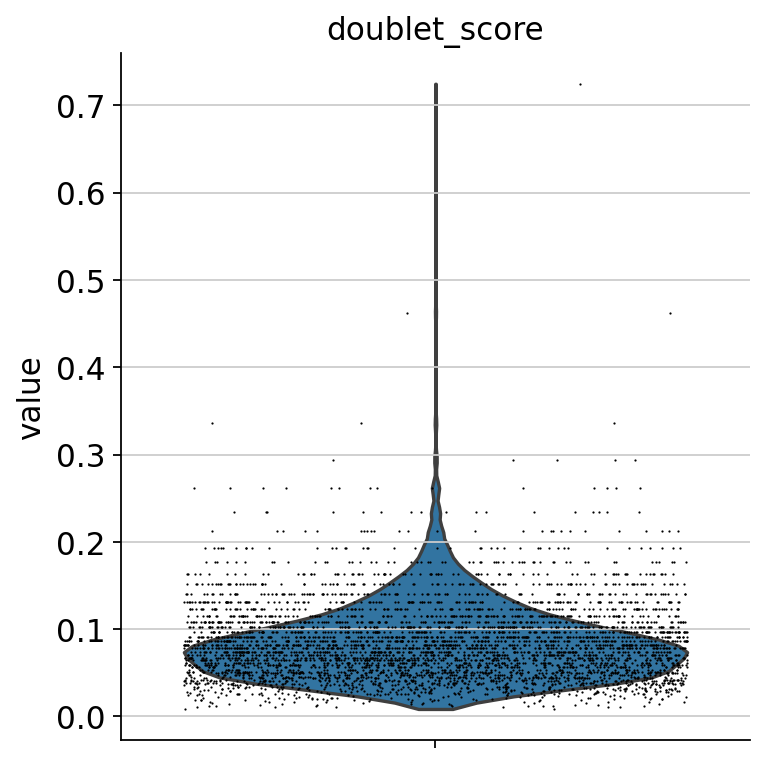

filtered out 33 cells that have less than 200 genes expressed
Running Scrublet
filtered out 17412 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:502: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sim = AnnData(scrub._E_sim)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.52
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.5%
    Scrublet finished (0:00:20)


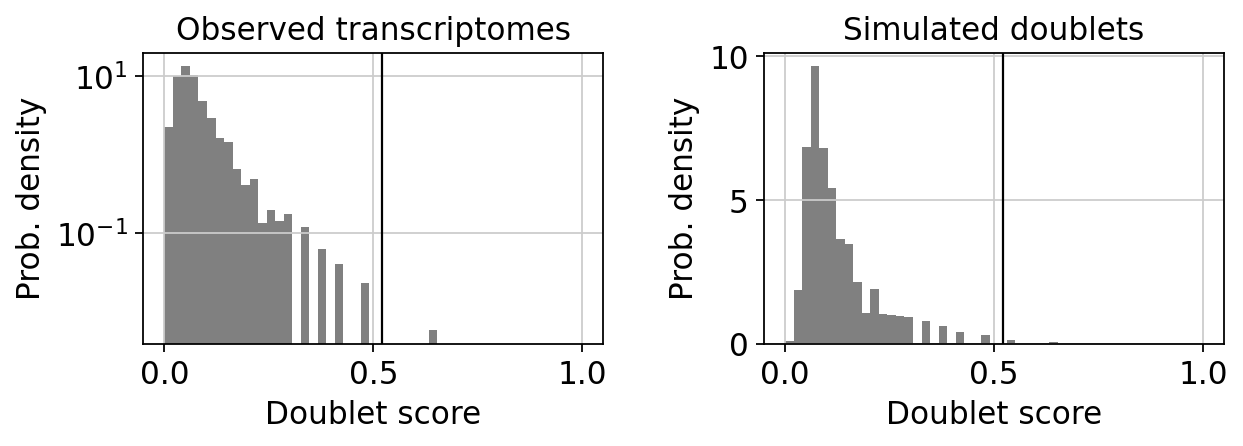

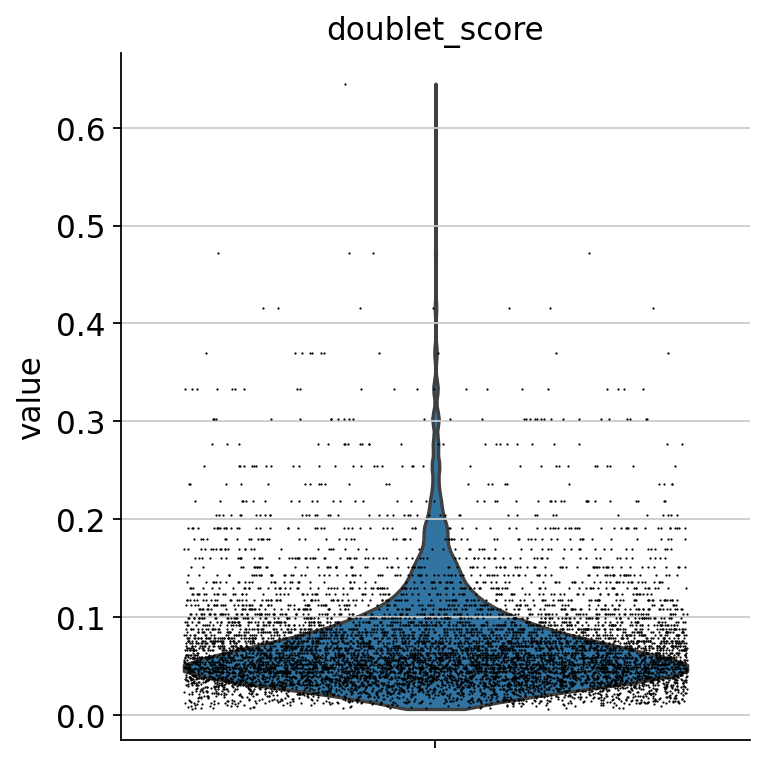

In [101]:
for sample in Sample_list:
    scanpyPreprocessing_SS(sample.mod['rna'])

In [102]:
HealthyBM1_rna = HealthyBM1.mod['rna'][HealthyBM1.mod['rna'].obs.doublet_score<0.2, :]
HealthyBM2_rna = HealthyBM2.mod['rna'][HealthyBM2.mod['rna'].obs.doublet_score<0.2, :]

In [103]:
AML335_rna = AML335.mod['rna'][AML335.mod['rna'].obs.predicted_doublet==False, :]
AML647_rna = AML647.mod['rna'][AML647.mod['rna'].obs.predicted_doublet==False, :]
AML882_rna = AML882.mod['rna'][AML882.mod['rna'].obs.predicted_doublet==False, :]
AML948_rna = AML948.mod['rna'][AML948.mod['rna'].obs.predicted_doublet==False, :]
AML1355_rna = AML1355.mod['rna'][AML1355.mod['rna'].obs.predicted_doublet==False, :]
AML3082_rna = AML3082.mod['rna'][AML3082.mod['rna'].obs.predicted_doublet==False, :]
AML3121_rna = AML3121.mod['rna'][AML3121.mod['rna'].obs.predicted_doublet==False, :]
AML3210_rna = AML3210.mod['rna'][AML3210.mod['rna'].obs.predicted_doublet==False, :]
AML3371_rna = AML3371.mod['rna'][AML3371.mod['rna'].obs.predicted_doublet==False, :]
AML3492_rna = AML3492.mod['rna'][AML3492.mod['rna'].obs.predicted_doublet==False, :]
AML4000_rna = AML4000.mod['rna'][AML4000.mod['rna'].obs.predicted_doublet==False, :]
AML4010_rna = AML4010.mod['rna'][AML4010.mod['rna'].obs.predicted_doublet==False, :]
AML4035_rna = AML4035.mod['rna'][AML4035.mod['rna'].obs.predicted_doublet==False, :]
AML4048_rna = AML4048.mod['rna'][AML4048.mod['rna'].obs.predicted_doublet==False, :]
AML4062_rna = AML4062.mod['rna'][AML4062.mod['rna'].obs.predicted_doublet==False, :]
AML4068_rna = AML4068.mod['rna'][AML4068.mod['rna'].obs.predicted_doublet==False, :]
AML4090_rna = AML4090.mod['rna'][AML4090.mod['rna'].obs.predicted_doublet==False, :]
AML4102_rna = AML4102.mod['rna'][AML4102.mod['rna'].obs.predicted_doublet==False, :]
AML4116_rna = AML4116.mod['rna'][AML4116.mod['rna'].obs.predicted_doublet==False, :]
AML4127_rna = AML4127.mod['rna'][AML4127.mod['rna'].obs.predicted_doublet==False, :]
AML4192_rna = AML4192.mod['rna'][AML4192.mod['rna'].obs.predicted_doublet==False, :]
AML4226_rna = AML4226.mod['rna'][AML4226.mod['rna'].obs.predicted_doublet==False, :]
AML4232_rna = AML4232.mod['rna'][AML4232.mod['rna'].obs.predicted_doublet==False, :]
AML4239_rna = AML4239.mod['rna'][AML4239.mod['rna'].obs.predicted_doublet==False, :]
AML4264_rna = AML4264.mod['rna'][AML4264.mod['rna'].obs.predicted_doublet==False, :]
AML4271_rna = AML4271.mod['rna'][AML4271.mod['rna'].obs.predicted_doublet==False, :]
AML4304_rna = AML4304.mod['rna'][AML4304.mod['rna'].obs.predicted_doublet==False, :]
AML4363_rna = AML4363.mod['rna'][AML4363.mod['rna'].obs.predicted_doublet==False, :]

In [104]:
AML335_rna = AML335.mod['rna'][AML335.mod['rna'].obs.doublet_score<0.3, :]
AML647_rna = AML647.mod['rna'][AML647.mod['rna'].obs.doublet_score<0.3, :]
AML882_rna = AML882.mod['rna'][AML882.mod['rna'].obs.doublet_score<0.3, :]
AML948_rna = AML948.mod['rna'][AML948.mod['rna'].obs.doublet_score<0.3, :]
AML1355_rna = AML1355.mod['rna'][AML1355.mod['rna'].obs.doublet_score<0.3, :]
AML3082_rna = AML3082.mod['rna'][AML3082.mod['rna'].obs.doublet_score<0.3, :]
AML3121_rna = AML3121.mod['rna'][AML3121.mod['rna'].obs.doublet_score<0.3, :]
AML3210_rna = AML3210.mod['rna'][AML3210.mod['rna'].obs.doublet_score<0.3, :]
AML3371_rna = AML3371.mod['rna'][AML3371.mod['rna'].obs.doublet_score<0.3, :]
AML3492_rna = AML3492.mod['rna'][AML3492.mod['rna'].obs.doublet_score<0.3, :]
AML4000_rna = AML4000.mod['rna'][AML4000.mod['rna'].obs.doublet_score<0.3, :]
AML4010_rna = AML4010.mod['rna'][AML4010.mod['rna'].obs.doublet_score<0.3, :]
AML4035_rna = AML4035.mod['rna'][AML4035.mod['rna'].obs.doublet_score<0.3, :]
AML4048_rna = AML4048.mod['rna'][AML4048.mod['rna'].obs.doublet_score<0.3, :]
AML4062_rna = AML4062.mod['rna'][AML4062.mod['rna'].obs.doublet_score<0.3, :]
AML4068_rna = AML4068.mod['rna'][AML4068.mod['rna'].obs.doublet_score<0.3, :]
AML4090_rna = AML4090.mod['rna'][AML4090.mod['rna'].obs.doublet_score<0.3, :]
AML4102_rna = AML4102.mod['rna'][AML4102.mod['rna'].obs.doublet_score<0.3, :]
AML4116_rna = AML4116.mod['rna'][AML4116.mod['rna'].obs.doublet_score<0.3, :]
AML4127_rna = AML4127.mod['rna'][AML4127.mod['rna'].obs.doublet_score<0.3, :]
AML4192_rna = AML4192.mod['rna'][AML4192.mod['rna'].obs.doublet_score<0.3, :]
AML4226_rna = AML4226.mod['rna'][AML4226.mod['rna'].obs.doublet_score<0.3, :]
AML4232_rna = AML4232.mod['rna'][AML4232.mod['rna'].obs.doublet_score<0.3, :]
AML4239_rna = AML4239.mod['rna'][AML4239.mod['rna'].obs.doublet_score<0.3, :]
AML4264_rna = AML4264.mod['rna'][AML4264.mod['rna'].obs.doublet_score<0.3, :]
AML4271_rna = AML4271.mod['rna'][AML4271.mod['rna'].obs.doublet_score<0.3, :]
AML4304_rna = AML4304.mod['rna'][AML4304.mod['rna'].obs.doublet_score<0.3, :]
AML4363_rna = AML4363.mod['rna'][AML4363.mod['rna'].obs.doublet_score<0.3, :]

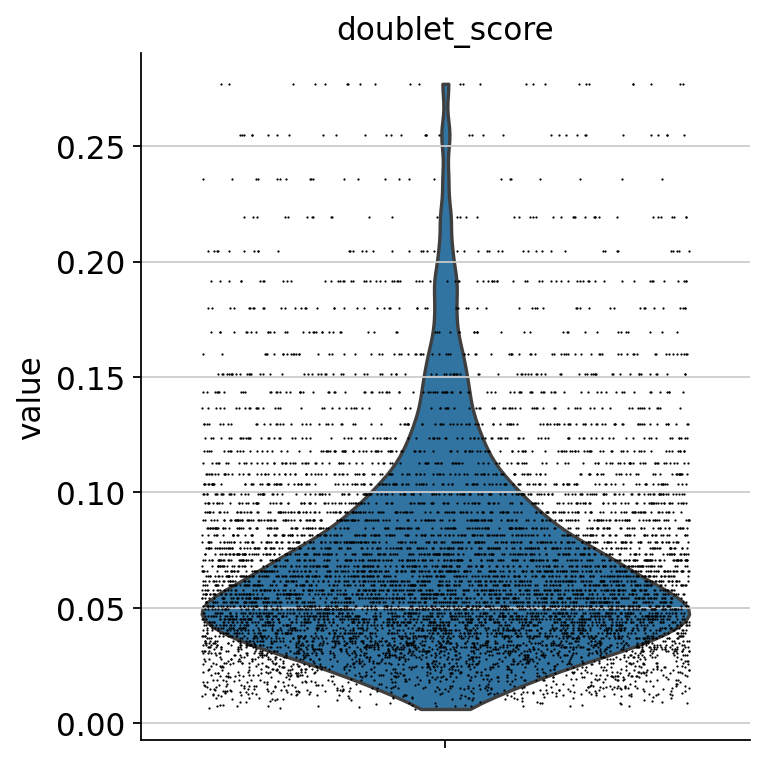

In [105]:
sc.pl.violin(AML4363_rna, ['doublet_score'],jitter=0.4, multi_panel=True)

In [106]:
HealthyBM1

MuData object with n_obs × n_vars = 5307 × 36622
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	5294 x 36601
      obs:	'n_genes', 'doublet_score', 'predicted_doublet'
      var:	'gene_ids', 'feature_types'
      uns:	'scrublet'
      layers:	'Raw_Counts'
    prot:	5307 x 21
      var:	'gene_ids', 'feature_types'

In [ ]:
#Process DownSample to the Samples with cell number larger than 3500

In [107]:
Cell_Num = 3500
RandomState=0

In [108]:
AML4363_S = sc.pp.subsample(AML4363_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4304_S = sc.pp.subsample(AML4304_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4271_S = sc.pp.subsample(AML4271_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4264_S = sc.pp.subsample(AML4264_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4239_S = sc.pp.subsample(AML4239_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)

In [109]:
AML4232_S = sc.pp.subsample(AML4232_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4226_S = sc.pp.subsample(AML4226_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4192_S = sc.pp.subsample(AML4192_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4127_S = sc.pp.subsample(AML4127_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML4116_S = sc.pp.subsample(AML4116_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4102_S = sc.pp.subsample(AML4102_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)

In [110]:
AML4090_S = sc.pp.subsample(AML4090_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML4068_S = sc.pp.subsample(AML4068_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML4062_S = sc.pp.subsample(AML4062, n_obs = Cell_Num,random_state=0, copy=True)
AML4035_S = sc.pp.subsample(AML4035_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML4010_S = sc.pp.subsample(AML4010, n_obs = Cell_Num,random_state=0, copy=True)
AML4000_S = sc.pp.subsample(AML4000_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)

In [111]:
AML3492_S = sc.pp.subsample(AML3492_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML3371_S = sc.pp.subsample(AML3371_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML3210_S = sc.pp.subsample(AML3210_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML3121_S = sc.pp.subsample(AML3121_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML3082_S = sc.pp.subsample(AML3082_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML1355_S = sc.pp.subsample(AML1355_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML948_S = sc.pp.subsample(AML948_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML882_S = sc.pp.subsample(AML882_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
#AML647_S = sc.pp.subsample(AML647_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)
AML335_S = sc.pp.subsample(AML335_rna, n_obs = Cell_Num,random_state=RandomState, copy=True)

In [112]:
Combo = HealthyBM1_rna.concatenate(HealthyBM2_rna,
                               AML335_S, 
                               AML647_rna,
                               AML882_S,
                               AML948_rna,
                               AML1355_S,
                               AML3082_S,
                               AML3121_S,
                               AML3210_S,
                               AML3371_rna,
                               AML3492_S,
                               AML4000_S, 
                               AML4010_rna,
                               AML4035_S,
                               AML4048_rna,
                               AML4062_rna,
                               AML4068_S,
                               AML4090_S,
                               AML4102_S,
                               AML4116_rna,
                               AML4127_S,
                               AML4192_S,
                               AML4226_S,
                               AML4232_S,
                               AML4239_S,
                               AML4264_S,
                               AML4271_S,
                               AML4304_S,
                               AML4363_S,batch_key='batch')

/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [11]:
file_path='/oak/stanford/groups/cgawad/home/Cancer_Studies/SC_RNA_SEQ/ALSF_AML/scanpy/H5AD/'

In [12]:
#Save raw data
Combo.write(file_path +"ALSF_AML_total_3500_raw_data.h5ad")

In [ ]:
#Sample annotation

In [15]:
batchDict = { 
'0':'0_HealthyBM1',
'1':'0_HealthyBM2',
'2':'CN',
'3':'del7q',
'4':'t(7;14)(q21;q32)',
'5':'CN',
'6':'PML/RARA',
'7':'CBFB/MYH11',
'8':'t(2;3)(p15;q26.2)',
'9':'MLLr',
'10':'Tri(15)',
'11':'PML/RARA',
'12':'MLLr',
'13':'CN',
'14':'MYB/GATA1',
'15':'MLLr',
'16':'CBFB/MYH11',
'17':'CN',
'18':'Tri(8)/MLLr',
'19':'RUNX1/RUNX1T1',
'20':'NUP98/NSD1',
'21':'Tri(8)',
'22':'Tri(8)/MLLr',
'23':'CN',
'24':'RUNX1/RUNX1T1',
'25':'CBFB/MYH11',
'26':'RUNX1/RUNX1T1',
'27':'CBFB/MYH11',
'28':'MLLr',
'29':'BCR/ABL'
            }

Combo.obs['Cytogenetic'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [16]:
batchDict = { 
'0':'0_HealthyBM1',
'1':'0_HealthyBM2',
'2':'FLT3/ITD',
'3':'del7q',
'4':'t(7;14)(q21;q32)',
'5':'FLT3/ITD',
'6':'PML/RARA',
'7':'CBFB/MYH11',
'8':'t(2;3)(p15;q26.2)',
'9':'MLLr',
'10':'Tri(15)//FLT3/ITD',
'11':'PML/RARA',
'12':'MLLr',
'13':'FLT3/ITD//NPM1c//IDH2-R140Q',
'14':'MYB/GATA1//PIK3CA-E542K',
'15':'MLLr//KRAS-G13D//ZFP36L2-fs',
'16':'CBFB/MYH11//NRAS-Q61K//MET-P991S',
'17':'FLT3/TKD',
'18':'Tri(8)//MLLr//IDH2-R172K',
'19':'RUNX1/RUNX1T1//TET2-C1271*//CSF3R-S783fs//JAK3-M511I//NCOR1-R933*',
'20':'NUP98/NSD1//WT1-S364LfsTer//KRAS-G12D//USP37-Q484',
'21':'Tri(8)',
'22':'Tri(8)//MLLr//FLT3-S451F//SPI1-R231C//BCORL1-fs',
'23':'NRAS-G12D//SOS1-R552K',
'24':'RUNX1/RUNX1T1',
'25':'CBFB/MYH11//KIT-D816V',
'26':'RUNX1/RUNX1T1//NRAS-G13D//SMARCB1-R40Q',
'27':'CBFB/MYH11//NRAS-G13D//KRAS-G13D//PTEN-R234P',
'28':'MLLr//NRAS-Q61K',
'29':'BCR/ABL//FLT3-D835(TKD)'
            }

Combo.obs['Genetic subtype'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [17]:
batchDict = { 
'0':'0_HealthyBM1',
'1':'0_HealthyBM2',
'2':'M5',
'3':'M4',
'4':'MPAL',
'5':'M2',
'6':'M3',
'7':'M4Eo',
'8':'MPAL',
'9':'M5',
'10':'M5',
'11':'M3',
'12':'M2',
'13':'FLT3/ITD',
'14':'M6',
'15':'M5',
'16':'M4Eo',
'17':'M5',
'18':'M1',
'19':'M1',
'20':'M1',
'21':'Tri(8)',
'22':'M5',
'23':'M2',
'24':'M2',
'25':'M5',
'26':'RUNX1/RUNX1T1',
'27':'M4Eo',
'28':'M2',
'29':'MPAL'
            }

Combo.obs['FAB'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [18]:
batchDict = { 
'0':'0_HealthyBM1',
'1':'0_HealthyBM2',
'2':'AML335',
'3':'AML647',
'4':'AML882',
'5':'AML948',
'6':'AML1355',
'7':'AML3082',
'8':'AML3121',
'9':'AML3210',
'10':'AML3371',
'11':'AML3492',
'12':'AML4000',
'13':'AML4010',
'14':'AML4035',
'15':'AML4048',
'16':'AML4062',
'17':'AML4068',
'18':'AML4090',
'19':'AML4102',
'20':'AML4116',
'21':'AML4127',
'22':'AML4192',
'23':'AML4226',
'24':'AML4232',
'25':'AML4239',
'26':'AML4264',
'27':'AML4271',
'28':'AML4304',
'29':'AML4363'
            }

Combo.obs['SampleID'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [19]:
batchDict = { 
'0':'0_HealthyBM',
'1':'0_HealthyBM',
'2':'1-10',
'3':'>20',
'4':'>10',
'5':'1-10',
'6':'1-10',
'7':'1-10',
'8':'>10',
'9':'1-10',
'10':'>10',
'11':'>10',
'12':'>10',
'13':'>10',
'14':'0-1',
'15':'0-1',
'16':'1-10',
'17':'>20',
'18':'>10',
'19':'1-10',
'20': '>10',
'21':'>20',
'22':'1-10',
'23':'1-10',
'24':'1-10',
'25':'>10',
'26':'>10',
'27':'>10',
'28':'1-10',
'29':'>10',
            }

Combo.obs['Age'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [20]:
batchDict = { 
'0':'0_HealthyBM',
'1':'0_HealthyBM',
'2' :'Alive',
'3' :'Deceased',
'4' :'Deceased',
'5' :'Alive',
'6' :'Alive',
'7' :'Alive',
'8' :'Deceased',
'9' :'Alive',
'10' :'Deceased',
'11' :'Alive',
'12' :'Deceased',
'13' :'Alive',
'14' :'Alive',
'15' :'Alive',
'16' :'Alive',
'17' :'Deceased',
'18' :'Alive',
'19' :'Alive',
'20' :'Alive',
'21' :'Alive',
'22' :'Alive',
'23' :'Alive',
'24' :'Alive',
'25' :'Alive',
'26' :'Alive',
'27' :'Deceased',
'28' :'Deceased',
'29' :'Alive',
            }

Combo.obs['Prognosis'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [21]:
batchDict = { 
'0':'0_HealthyBM',
'1':'0_HealthyBM',
'2':'False',
'3':'False',
'4':'False',
'5':'True',
'6':'False',
'7':'True',
'8':'False',
'9':'False',
'10':'True',
'11':'True',
'12':'False',
'13':'False',
'14':'False',
'15':'False',
'16':'False',
'17':'True',
'18':'False',
'19':'False',
'20':'False',
'21':'False',
'22':'False',
'23':'False',
'24':'False',
'25':'True',
'26':'False',
'27':'False',
'28':'True',
'29':'False'
            }

Combo.obs['Relapsed'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [22]:
batchDict = { 
'0':'0_HealthyBM',
'1':'0_HealthyBM',
'2':'True',
'3':'True',
'4':'False',
'5':'True',
'6':'True',
'7':'True',
'8':'False',
'9':'True',
'10':'True',
'11':'True',
'12':'True',
'13':'True',
'14':'True',
'15':'True',
'16':'True',
'17':'True',
'18':'True',
'19':'True',
'20':'True',
'21':'True',
'22':'True',
'23':'True',
'24':'True',
'25':'True',
'26':'True',
'27':'False',
'28':'True',
'29':'True',
            }

Combo.obs['Remission'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [23]:
batchDict = { 
'0':'HealthyBM',
'1':'HealthyBM',
'2':'AML',
'3':'AML',
'4':'AML',
'5':'AML',
'6':'AML',
'7':'AML',
'8':'AML',
'9':'AML',
'10':'AML',
'11':'AML',
'12':'AML',
'13':'AML',
'14':'AML',
'15':'AML',
'16':'AML',
'17':'AML',
'18':'AML',
'19':'AML',
'20':'AML',
'21':'AML',
'22':'AML',
'23':'AML',
'24':'AML',
'25':'AML',
'26':'AML',
'27':'AML',
'28':'AML',
'29':'AML',
            }

Combo.obs['SampleType'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [24]:
batchDict = { 
'0':'0_HealthyBM1',
'1':'0_HealthyBM2',
'2':'AML335-M5a-FLT3/ITD',
'3':'AML647-M4-del7q',
'4':'AML882-MPAL-t(7;14)(q21;q32)',
'5':'AML948-M2-FLT3/ITD',
'6':'AML1355-M3-PML/RARA',
'7':'AML3082-M4Eo-CBFB/MYH11',
'8':'AML3121-MPAL-t(2;3)(p15;q26.2)',
'9':'AML3210-M5a-MLLr',
'10':'AML3371-M5b-FLT3/ITD-Tri(15)',
'11':'AML3492-M3-PML/RARA',
'12':'AML4000-M2-MLLr',
'13':'AML4010-FLT3/ITD',
'14':'AML4035-M6-MYB/GATA1',
'15':'AML4048-M5-MLLr',
'16':'AML4062-CBFB/MYH11',
'17':'AML4068-M5b-FLT3/TKD',
'18':'AML4090-M1-Tri(8)/MLLr',
'19':'AML4102-M1-RUNX1/RUNX1T1',
'20':'AML4116-M1-NUP98/NSD1',
'21':'AML4127-Tri(8)',
'22':'AML4192-M5a-Tri(8)/MLLr',
'23':'AML4226-M2-NRAS(G12D)',
'24':'AML4232-M2-RUNX1/RUNX1T1',
'25':'AML4239-M5a-CBFB/MYH11',
'26':'AML4264-RUNX1/RUNX1T1',
'27':'AML4271-CBFB/MYH11',
'28':'AML4304-M2-MLLr',
'29':'AML4363-MPAL-BCR/ABL'
            
            
}

Combo.obs['Sample'] = (
    Combo.obs['batch']
    .map(batchDict)
    .astype('category')
)

In [12]:
file_path='/oak/stanford/groups/cgawad/home/Cancer_Studies/SC_RNA_SEQ/ALSF_AML/scanpy/H5AD/'

In [ ]:
#Save raw data
#Combo.write(file_path +"ALSF_AML_Combo_3500_with_raw_count.h5ad")

In [13]:
Combo=sc.read_h5ad(file_path+ "ALSF_AML_Combo_3500_with_raw_count.h5ad")

In [14]:
Combo.uns['log1p']["base"] = None

In [ ]:
mdata_prot=sc.read_h5ad(file_path +"ALSF_AML_total_3500_protein.h5ad")

In [ ]:
Combo

In [ ]:
mdata_prot

## Clustering with RNA data only
Calculate the neighborhood graph using PCA, and cluster it using leiden clustering.

In [25]:
#recover raw counts 
Combo.X=Combo.layers['Raw_Counts']

filtered out 9127 genes that are detected in less than 3 cells
104571 27474
normalizing counts per cell
    finished (0:00:03)


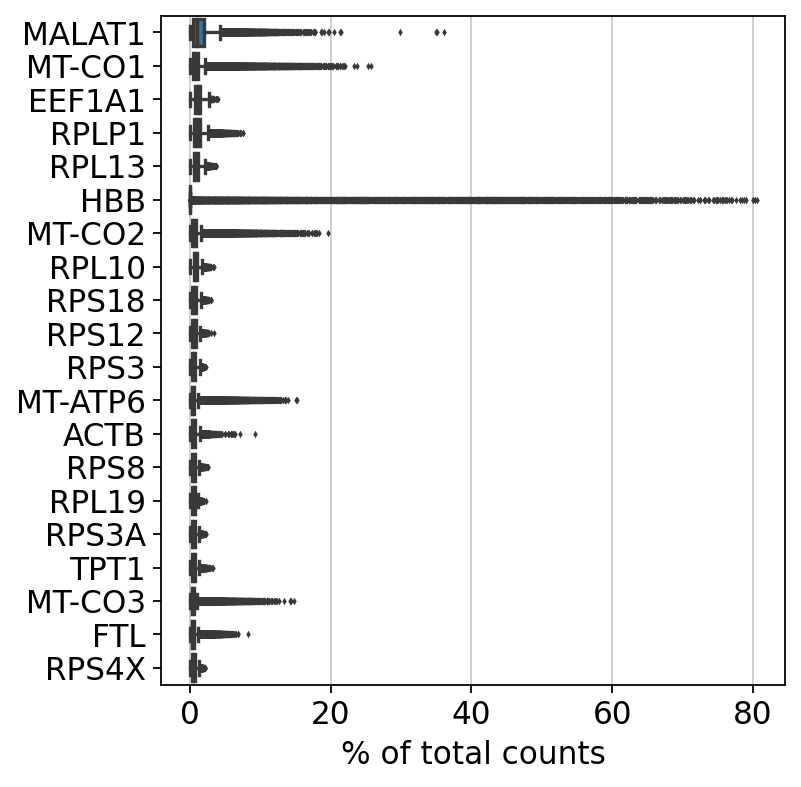

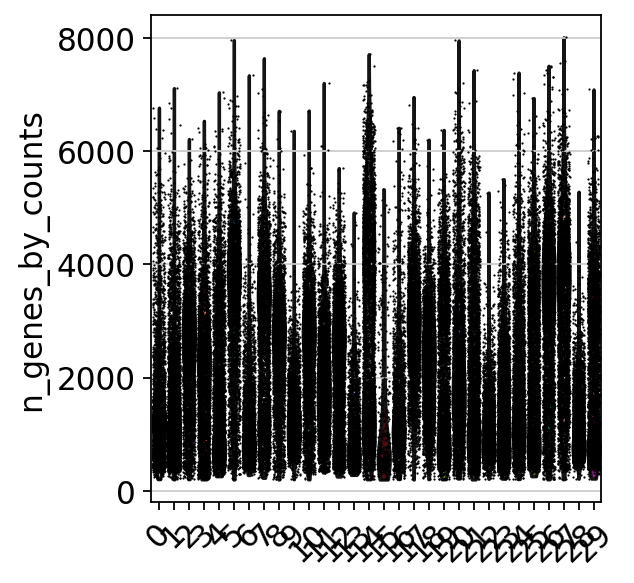

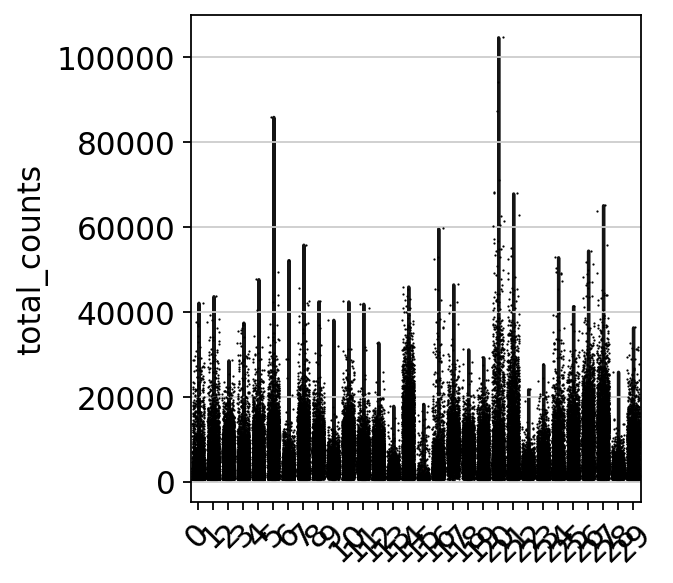

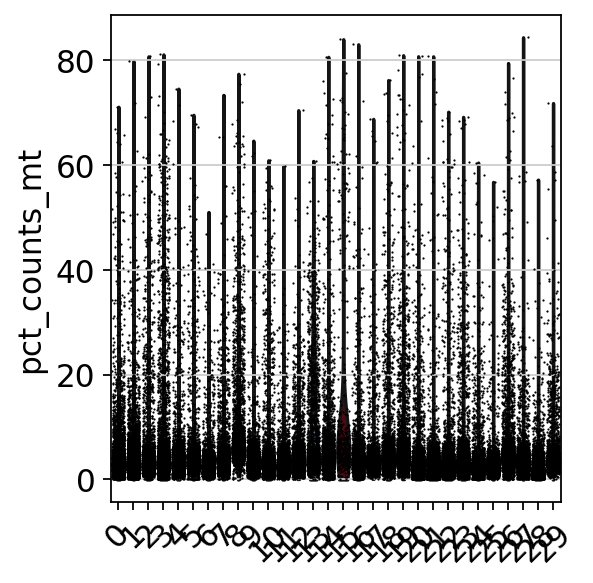

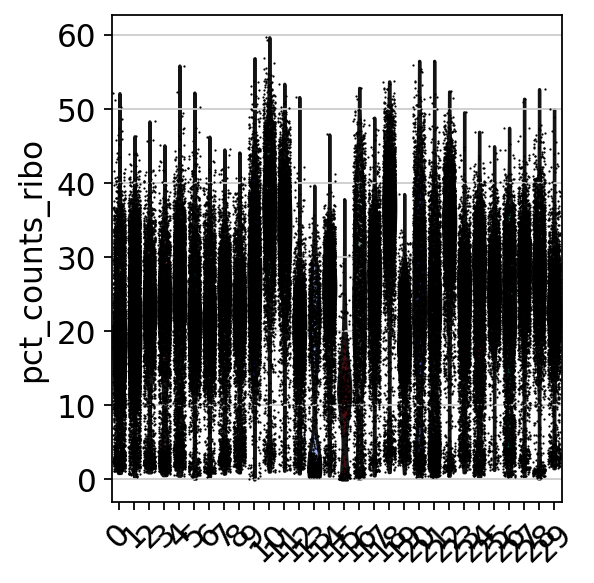

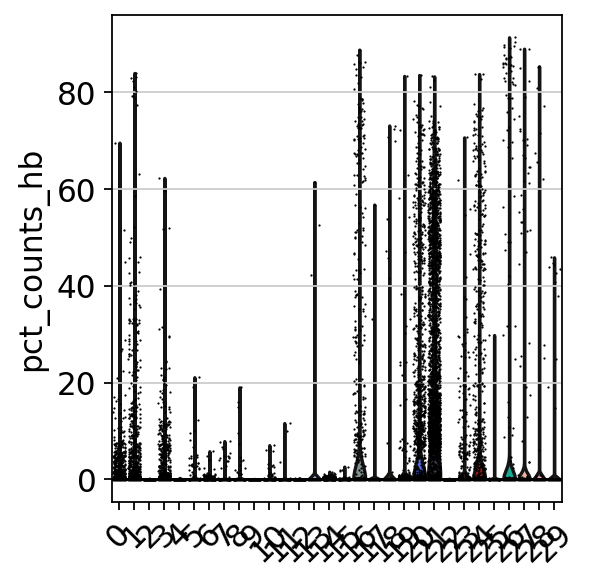

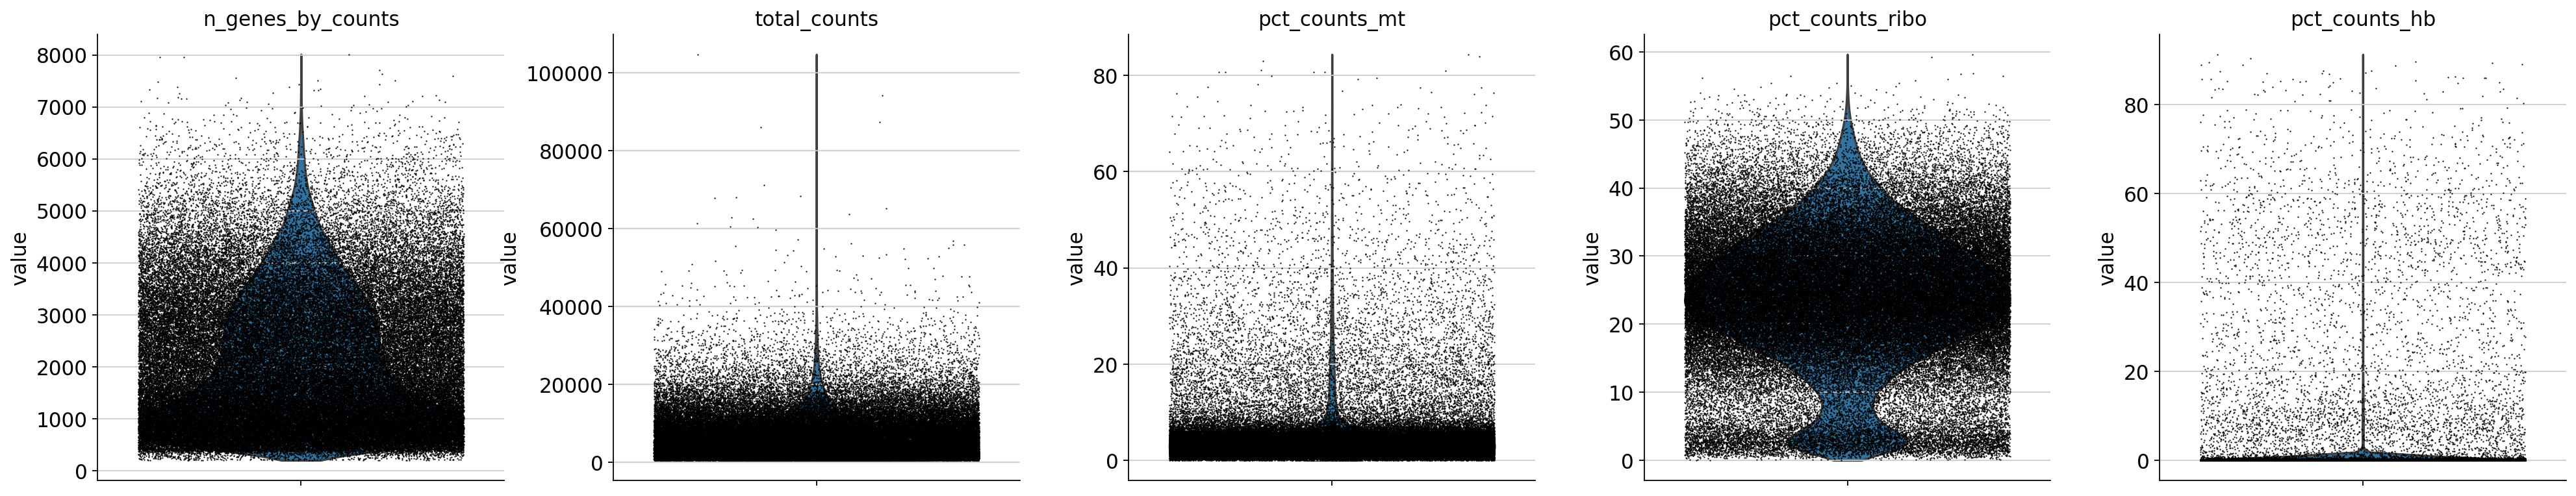

Remaining cells 104571


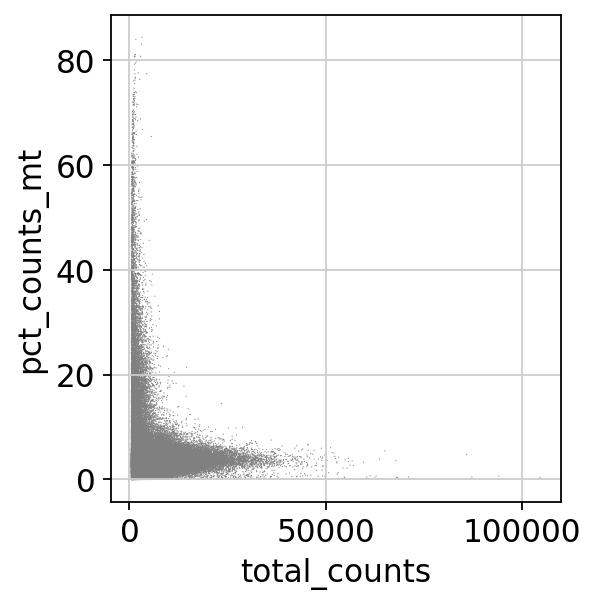

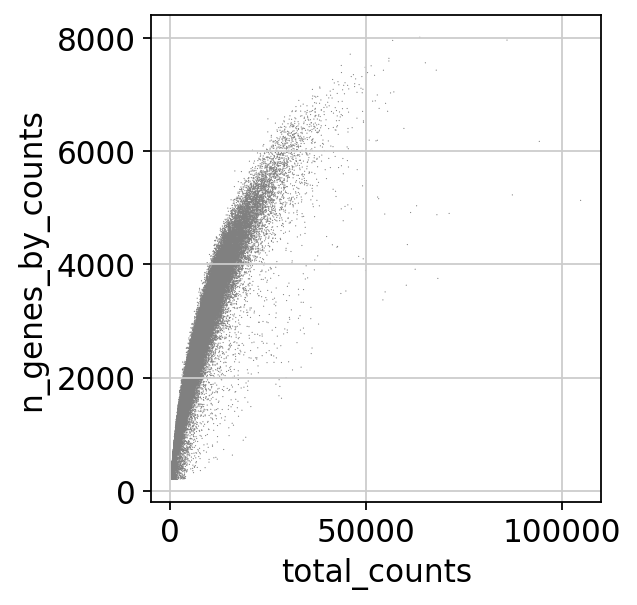

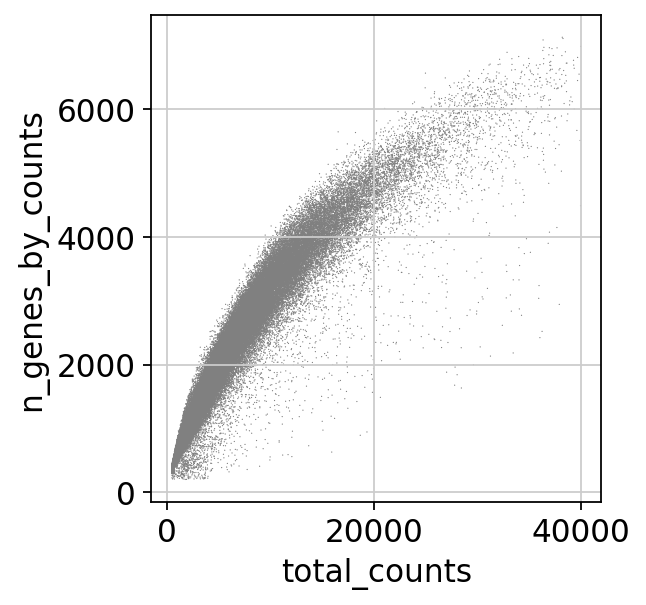

Remaining cells 96627


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:02)


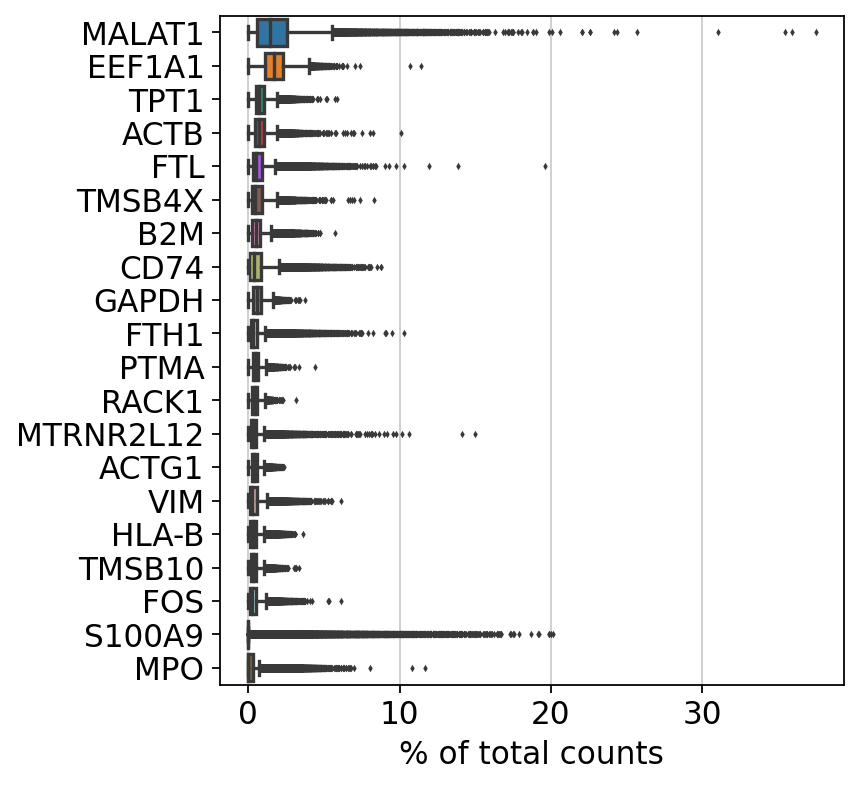

normalizing counts per cell
    finished (0:00:01)


In [26]:
Combo = scanpyPreprocessing(Combo)

In [27]:
Combo

AnnData object with n_obs × n_vars = 96627 × 27346
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'batch', 'Cytogenetic', 'Genetic subtype', 'FAB', 'SampleID', 'Age', 'Prognosis', 'Relapsed', 'Remission', 'SampleType', 'Sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_colors', 'log1p'
    layers: 'Raw_Counts', 'counts'

In [28]:
sc.pp.highly_variable_genes(Combo, min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5,
                            batch_key='batch')

extracting highly variable genes


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg =

/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg =

    finished (0:00:22)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


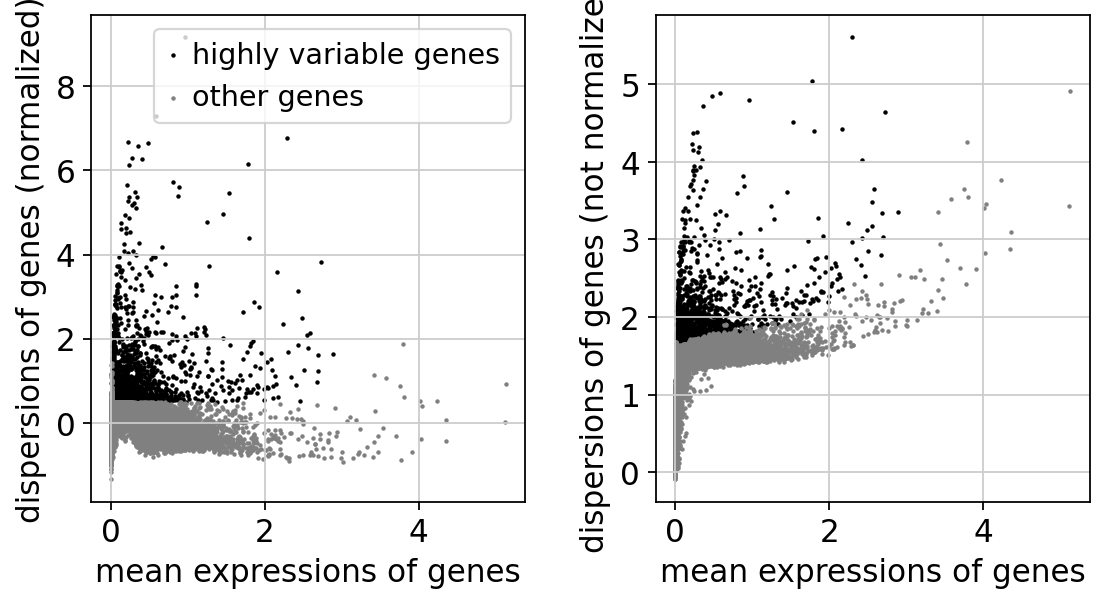

In [29]:
sc.pl.highly_variable_genes(Combo) 

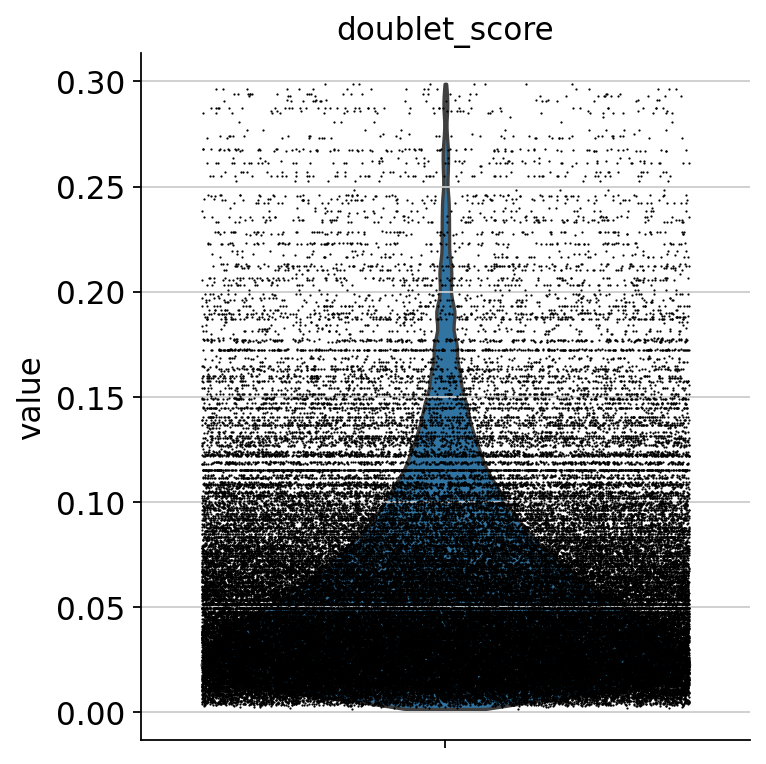

In [30]:
sc.pl.violin(Combo, ['doublet_score'],jitter=0.4, multi_panel=True)

In [31]:
#Combo = Combo[Combo.obs.doublet_score < 0.3, :]
#Combo = Combo[Combo.obs.predicted_doublet==False, :]

In [33]:
sc.pp.scale(Combo, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [34]:
sc.pp.combat(Combo)

Standardizing Data across genes.

Found 30 batches

Found 0 numerical variables:
	

Found 1 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


Adjusting data



In [36]:
sc.tl.pca(Combo, svd_solver='arpack',n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:03)


In [37]:
sc.pp.neighbors(Combo, n_neighbors=50, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:05)


In [38]:
sc.tl.umap(Combo,min_dist=0.5,spread=6)


computing UMAP


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:22)


In [39]:
sc.tl.leiden(Combo, resolution=6.5)

running Leiden clustering
    finished: found 102 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:11)


/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/oak/stanford/groups/cgawad/Sequencing_Analysis_Tools/scRNA_py3.7/envs/pyscenic_3.8/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


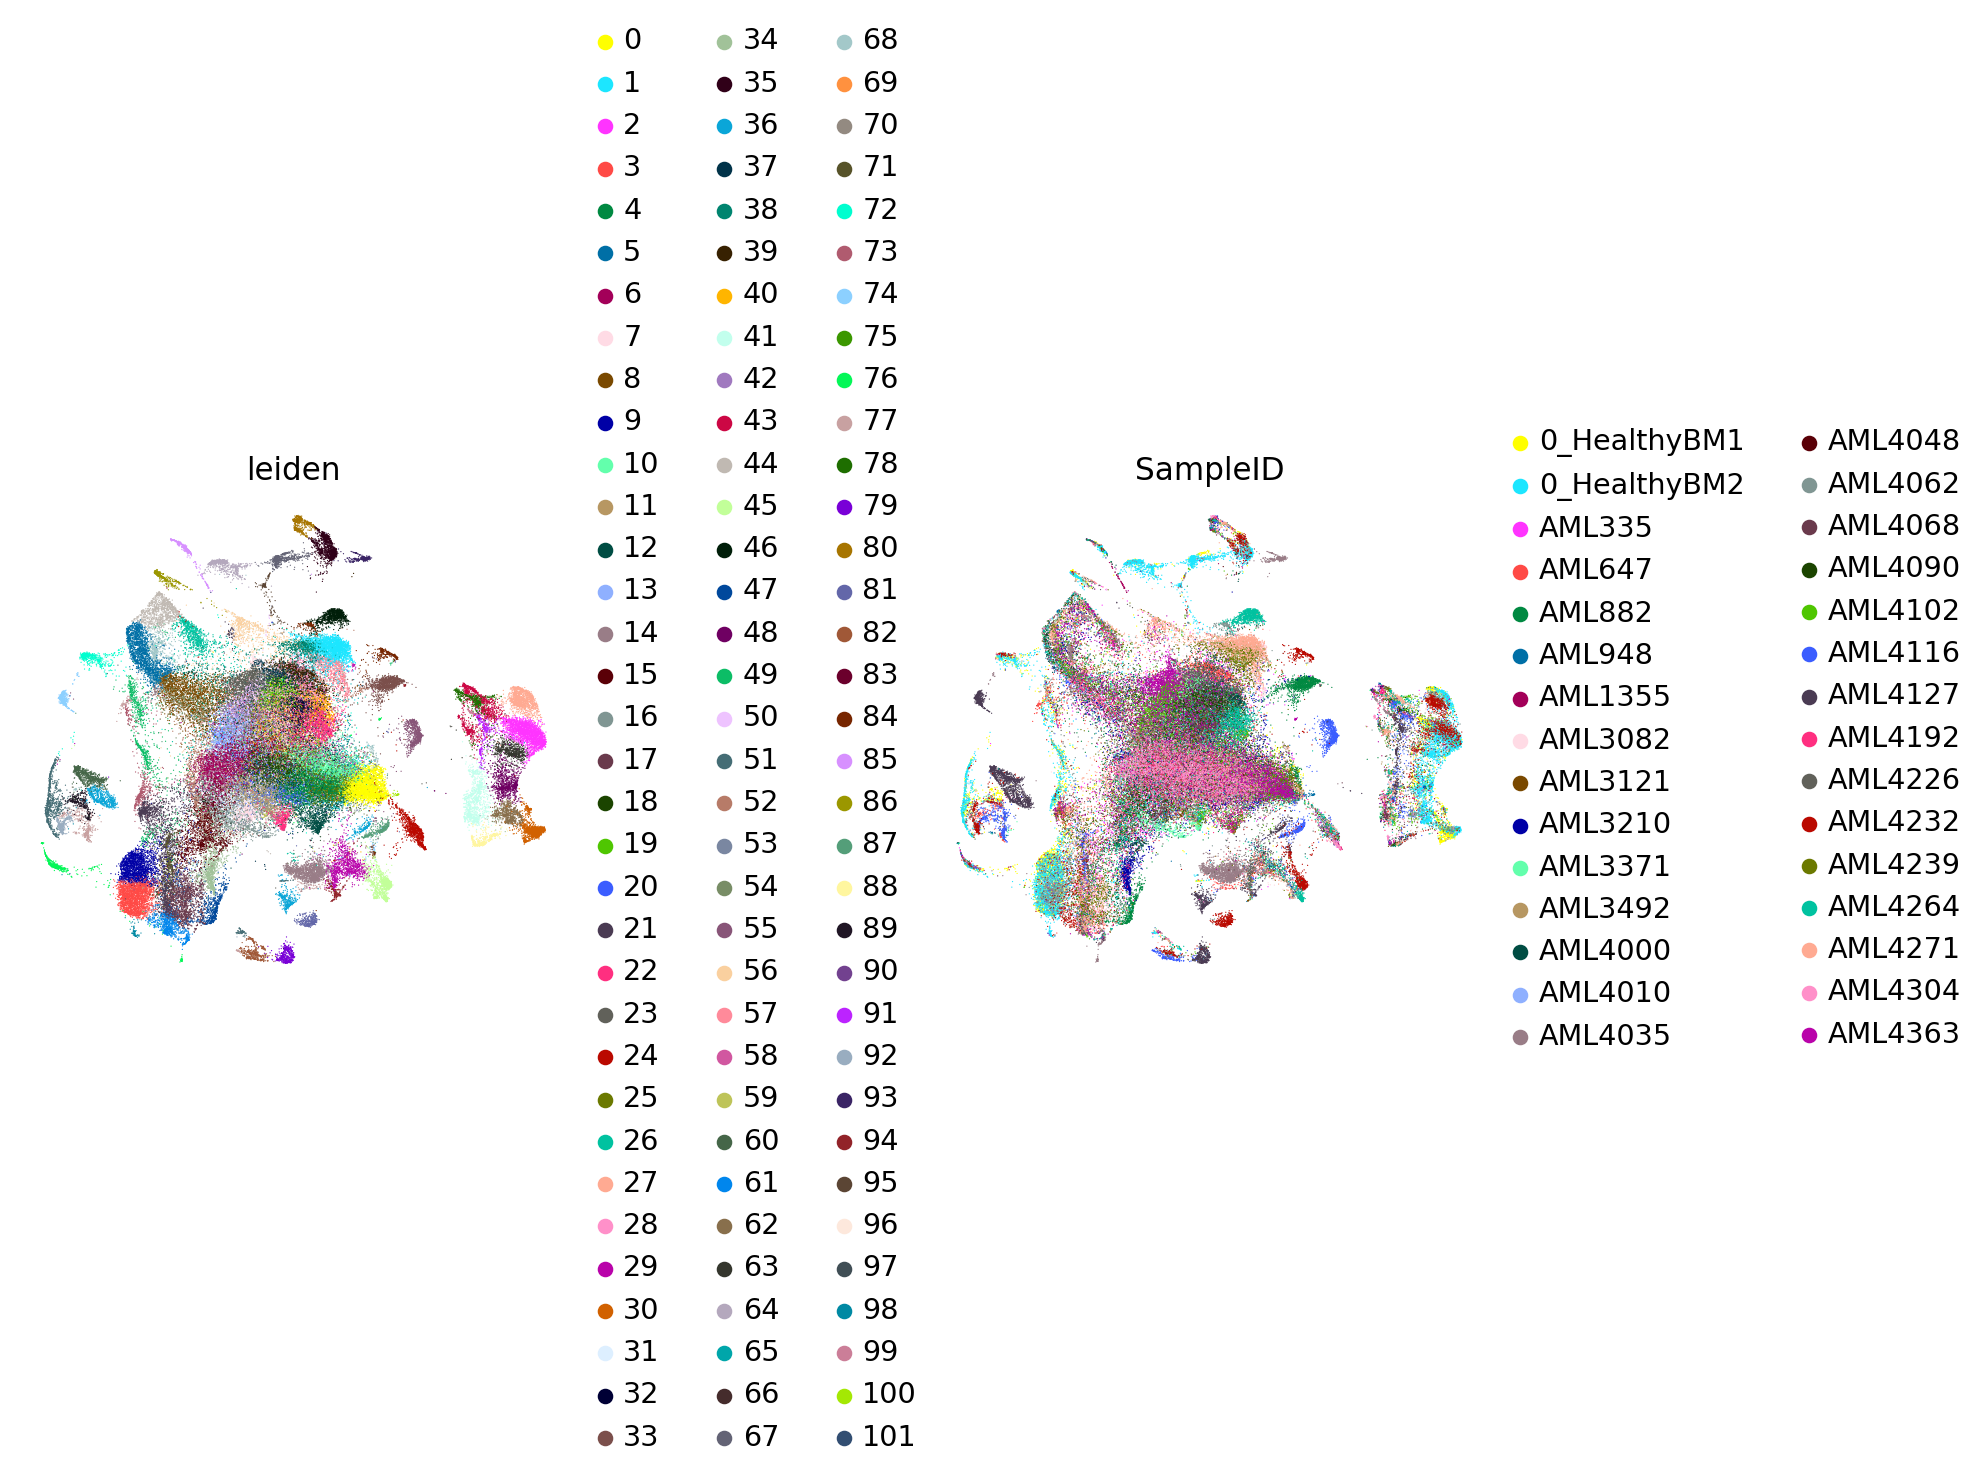

In [40]:
sc.pl.umap(Combo, color=['leiden', 'SampleID'], wspace = 0.5, 
       
           frameon=False)
    

In [ ]:
sc.pl.umap(Combo, color=[ "doublet_score",'total_counts','n_genes_by_counts'],cmap='bwr')

In [ ]:
sc.pl.violin(Combo, "doublet_score")

In [ ]:
sc.pl.umap(Combo, color=['FAB','Cytogenetic'], wspace=0.3, legend_fontsize = 10,frameon=False,
          save="_Combo_FAB_CYtogenetic.png") 


In [ ]:
sc.pl.umap(Combo, color=['Prognosis','Relapsed','Remission'], wspace=0.3, legend_fontsize = 10,frameon=False,
           save="_Combo_Prognosis-Relapsed-Remission.png") 



In [ ]:
sc.pl.umap(Combo, color=['Age'], wspace=0.3, legend_fontsize = 10,frameon=False,
           save="_Combo_age.png") 



In [ ]:
Combo.write(file_path + "ALSF_AML_Combo_3500_with_raw_count.h5ad")

## Marker Genes

## Cell Type Assignment and Gene Expression Plots
Based on the top 10 genes in each leiden cluster and manual literature search, assigned cell types to each leiden cluster. Creating a new observation called "Cell Type".

In [ ]:
# Marker genes for each lineage
sc.pl.umap(Combo, color=[      'EPCAM',#'AFP','ALB',# Hepatocytes
                               'PTPRC', 'CD34','CD38','AVP',#HSC CD34+CD38-SPINK2+AVP-IL3RA-IL7R-
                               'FLT3','IL3RA',#myeloid progenitors
                               'VCAN','CCR2','CD14','CD1C',
                               'CD68','HES4','FCGR3A','KLF4',#Monocytes precursor
                               #'SPIC',#'TMEM132E',# Macrophage
                               'MPO','AZU1',# Graunulocytes precursor
                               #'CEACAM8',# Neutrophils
                               'GATA1','KLF1',# Erythrocytes precursor
                               'PF4',# Megakaryocytes
                               'MS4A3',# Mast cells and Basophlis
                               'GYPA','GYPB',# Erythrocytes
                               'CD7','CD3D','CD4','CD8A','CCR7',# T cells
                               'KLRB1','GNLY','GZMB','GZMA','GZMH',# NK cells
                               'IL7R','CD19','MME','EBF1','PAX5','MS4A1',# B cells
                               'PCNA','MKI67',#cell cycle
                                'ITGA6',
                                'IGHA2','TNFRSF17',#plasma B cell
                                'CD96','GTSF1','ATP8B4','CCNA1',
                                'TPSAB1','CD9','HGF','PF4'
                         
                                 ], cmap='Reds', 
          # save='_ALSF_AML_rna_lineage_markers.png'
          )

In [ ]:
sc.pl.umap(Combo, color=['SampleID','leiden'], wspace=0.6,frameon=False)

In [ ]:
#UMAP plot for each leiden cluster

In [ ]:
leiden_lis=pd.DataFrame(Combo.obs['leiden'])['leiden'].unique().tolist()

In [ ]:
leiden_lis.sort()

In [ ]:
# Marker genes for each lineage
for group in leiden_lis:
    
    sc.pl.umap(Combo, color=['leiden'],groups=group,frameon=False)

In [ ]:
#Cluster annotation

In [ ]:
Combo_leiden2manCT = {
   
  '0': 'AML',
  '1': 'AML',
  '2': 'Naive CD4T',
  '3': 'AML',
  '4': 'AML',
  '5': 'AML',
  '6': 'AML',
  '7': 'AML',
  '8': 'AML',
  '9': 'AML-CD14',
  '10': 'AML-PCNA',
  '11': 'AML',
  '12': 'CD14_Monocyte',
  '13': 'AML',
  '14': 'AML',
  '15': 'AML',
  '16': 'AML',
  '17': 'AML',
  '18': 'AML-CD14',
  '19': 'AML',
  '20': 'AML-MKI67',
  '21': 'AML',
  '22': 'AML',
  '23': 'AML-MKI67',
  '24': 'AML',
  '25': 'AML-CD14',
  '26': 'AML',
  '27': 'CD14_Monocyte',
  '28': 'AML',
  '29': 'AML',
  '30': 'AML',
  '31': 'AML-mDC',
  '32': 'AML',
  '33': 'CTL',
  '34': 'AML',
  '35': 'AML',
  '36': 'AML',
  '37': 'AML-CD4T',
  '38': 'AML-CD14',
  '39': 'AML',
  '40': 'AML-ATP8B4',
  '41': 'pDC',
  '42': 'Naive CD8T',
  '43': 'AML',
  '44': 'AML-CTL',
  '45': 'AML',
  '46': 'AML',
  '47': 'AML',
  '48': 'AML',
  '49': 'Erythrocytes',
  '50': 'CD20+B',
  '51': 'AML',
  '52': 'NK',
  '53': 'AML',
  '54': 'AML',
  '55': 'AML-MKI67',
  '56': 'AML',
  '57': 'AML',
  '58': 'AML',
  '59': 'AML',
  '60': 'AML',
  '61': 'AML-Ery',
  '62': 'Myeloid Pro',
  '63': 'AML',
  '64': 'AML',
  '65': 'AML-Ery',
  '66': 'AML',
  '67': 'AML',
  '68': 'AML-Ery',
  '69': 'PreB',
  '70': 'AML-CD8T',
  '71': 'AML-B',
  '72': 'AML',
  '73': '0_HSPC',
  '74': 'CD14_Monocyte',
  '75': 'AML-Ery',
  '76': 'AML-B',
  '77': 'pDC',
  '78': 'AML',
  '79': 'PlasmaB',
  '80': 'AML',
  '81': 'AML',
  '82': 'AML',
  '83': 'AML-Ery',
  '84': 'AML-B',
  '85': 'AML-CD16',
  '86': 'PreB',
  '87': 'Macrophage',
  '88': 'AML',
  '89': 'AML',
  '90': 'AML',
  '91': 'AML',

   
}
Combo.obs['Cell_Type'] = (
   Combo.obs['leiden']
    .map(Combo_leiden2manCT)
    .astype('category')
)

In [ ]:
Combo_leiden2manCT = {
  '0': 'AML',
  '1': 'Monocyte',
  '2': 'AML',
  '3': 'Naïve T',
  '4': 'AML',
  '5': 'AML',
  '6': 'AML',
  '7': 'AML',
  '8': 'AML',
  '9': 'AML-CD14',
  '10': 'AML',
  '11': 'AML',
  '12': 'AML',
  '13': 'AML',
  '14': 'CTL',
  '15': 'AML',
  '16': 'AML-CellCycle',
  '17': 'Monocyte',
  '18': 'AML',
  '19': 'AML',
  '20': 'AML',
  '21': 'AML',
  '22': 'AML',
  '23': 'AML',
  '24': 'AML',
  '25': 'AML',
  '26': 'AML',
  '27': 'Naïve T',
  '28': 'NK',
  '29': 'AML',
  '30': 'B',
  '31': 'AML-CellCycle',
  '32': 'AML',
  '33': 'AML',
  '34': 'AML',
  '35': 'AML-mDC',
  '36': 'AML',
  '37': 'Myeloid Pro',
  '38': 'AML',
  '39': 'AML-CD4T',
  '40': 'AML',
  '41': 'AML-CTL',
  '42': 'AML-CellCycle',
  '43': 'AML',
  '44': 'AML',
  '45': 'AML-Ery',
  '46': 'AML-CellCycle',
  '47': 'AML',
  '48': 'AML',
  '49': 'Erythrocytes',
  '50': 'AML-CD14',
  '51': 'AML-CD8T',
  '52': 'AML',
  '53': 'AML',
  '54': 'AML-Ery',
  '55': 'Activated CD4T',
  '56': 'AML',
  '57': 'AML',
  '58': 'AML',
  '59': 'AML-Ery',
  '60': 'B',
  '61': 'B',
  '62': 'AML',
  '63': 'AML',
  '64': 'AML',
  '65': 'AML',
  '66': 'AML',
  '67': '0_HSPC',
  '68': 'AML',
  '69': 'AML-NK',
  '70': 'AML',
  '71': 'AML',
  '72': 'mDC',
  '73': 'AML-Ery',
  '74': 'Monocyte',
  '75': 'AML-Ery',
  '76': 'AML-B',
  '77': 'pDC',
  '78': 'AML',
  '79': 'PlasmaB',
  '80': 'AML',
  '81': 'AML',
  '82': 'AML',
  '83': 'AML-Ery',
  '84': 'AML-B',
  '85': 'AML-CD16',
  '86': 'B',
  '87': 'Macrophage',
  '88': 'AML',
  '89': 'AML',
  '90': 'AML',
  '91': 'AML',



   
}
Combo.obs['lineage'] = (
   Combo.obs['leiden']
    .map(Combo_leiden2manCT)
    .astype('category')
)

In [ ]:
sc.pl.umap(Combo, color=['Cell_Type'],
            #legend_loc='on data', 
           legend_fontsize = 6
          )

In [ ]:
sc.pl.umap(Combo, color=['lineage'],
            #legend_loc='on data', 
           legend_fontsize = 6
          )

In [ ]:
sc.pl.umap(Combo, color=['lineage','Sample'], wspace=0.6, legend_fontsize = 10,frameon=False,
           save="_Combo_lineage_Sample.png") 

In [ ]:
sc.pl.umap(Combo, color=['Cell_Type','Sample'], wspace=0.6, legend_fontsize = 10,frameon=False,
           save="_Combo_cluster_Sample.png") 

In [ ]:
sc.pl.umap(Combo, color=['Cell_Type','Cytogenetic'], wspace=0.6, legend_fontsize = 10,frameon=False,
           save="_Combo_Cytogenetic_Cell_Type.png") 

# Cell Cycle Score

In [ ]:
cell_cycle_genes = [x.strip() for x in open('regev_lab_cell_cycle_genes.txt')]

In [ ]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in Combo.var_names]

In [ ]:
sc.tl.score_genes_cell_cycle(Combo, s_genes=s_genes, g2m_genes=g2m_genes)

In [ ]:
phase_count=pd.DataFrame(Combo.obs['phase'])
phase_count_batch=pd.DataFrame(Combo.obs['Sample'])
phase_sum=phase_count_batch.join(phase_count)

In [ ]:
phase_sum=phase_sum.groupby(['Sample','phase']).size().to_frame('phase_sum')

In [ ]:
phase_sum.reset_index(inplace=True)
data = phase_sum.pivot(index=['Sample'], # Columns that will not change
columns='phase', # Column holding new column names/categories
values='phase_sum') # Name of value column to spread

data.to_csv('AML_scRNA_Cell_phase_total_cells.csv')
data

# Multi-omics integration

In [ ]:
mdata = mu.MuData({'rna': Combo, 'prot': mdata_prot})

In [ ]:
mu.pp.intersect_obs(mdata)

In [ ]:
prot=mdata.mod['prot']

In [ ]:
prot

In [ ]:
CSF_list=['CD19_pos', 'CD274_pos', 'CD3_pos', 'CD33_pos', 'CD90_pos', 'CD10_pos', 'CD45RA_pos', 'CD123_pos', 'CD7_pos', 'CD49f_pos', 'CD25_pos', 'CD279_pos', 'CD32_pos', 'CD152_pos', 
          'CD366_pos', 'CD235ab_pos', 'CD127_pos', 'CD71_pos', 'CD36_pos', 'CD133_pos']

In [ ]:
for CSF in CSF_list:
    Combo.obs[CSF]=prot.obs[CSF]

In [ ]:
Combo

In [ ]:
mu.tl.leiden(mdata, resolution=[3, .5], random_state=1)
mu.pl.embedding(mdata, basis="rna:X_umap", color=["leiden"])

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD235ab",'CD127','CD71','CD133'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3",'CD19-1','CD7-1','CD45RA'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD3",'CD3E','CD3D'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD7",'CD7-1'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD45",'CD33-1','CD90','CD10'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD123",'CD32','CD49f','CD25'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD274-1",'CD279','CD152','CD366'], cmap='Reds')

In [ ]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["CD32",'CD33-1','CD36-1'], cmap='Reds')

In [ ]:
prot=mdata.mod['prot']

In [ ]:
prot.var["highly_variable"] = True

In [ ]:
mdata.update()

In [ ]:
mu.tl.mofa(mdata, outfile=file_path +"ALSF_AML_CITEseq_2.hdf5",
           n_factors=30)

In [ ]:
mu.pl.mofa(mdata, color=['CD3', 'CD19-1'])

In [ ]:
sc.pp.neighbors(mdata, use_rep="X_mofa")

In [ ]:
sc.tl.umap(mdata, random_state=1)
mu.pl.umap(mdata, color=['rna:Cell_Type'], frameon=False,
           title="UMAP(MOFA) embedding with RNA celltype annotation")

In [ ]:
mu.pl.umap(mdata, color=['CD3', 'CD45RA', 'CD19-1'], frameon=False, cmap='viridis')

In [ ]:
mu.pl.mofa(mdata, color=['CD45RA', 'CD3'])

In [ ]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 150

In [ ]:
import mofax as mofa
model = mofa.mofa_model(file_path +"ALSF_AML_CITEseq_2.hdf5")

In [ ]:
mofa.plot_weights(model, factors=range(3), n_features=10, sharex=False)

In [ ]:
model.metadata["rna:Prognosis"] = model.metadata["rna:Prognosis"].astype('category').cat.reorder_categories(mdata['rna'].obs.Prognosis.cat.categories)

In [ ]:
with pl.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}):
    mofa.plot_factors_violin(model, color='rna:Prognosis', factors=range(3), violins=True )

In [ ]:
model.metadata["rna:Age"] = model.metadata["rna:Age"].astype('category').cat.reorder_categories(mdata['rna'].obs.Age.cat.categories)

In [ ]:
with pl.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}):
    mofa.plot_factors_violin(model, color='rna:Age', factors=range(3), violins=True )

In [ ]:
model.close()

In [ ]:
mdata.write(file_path +"ALSF_AML_CITEseq_Total_cells_muon.h5mu")